# Business Analytics B - Gruppenprojekt "Katalonia"

### Modulbeschreibung:

- Studiengang: Business Analytics
- Modul: Business Analytics B
- Semester: Wintersemester 20/21
- Dozent: Prof. Dr. Jan Schemm
- Bearbeitungszeitraum: 05.01.2021 - 12.02.2021

### Gruppenmitglieder:

- Bröcker, Melina (Mat. Nr.862393)
- Himmelmann, Friederike (Mat. Nr.843905)
- Lutz, Mirijam (Mat. Nr.866605)
- Liebetrau, Daniel (Mat. Nr.858470)

### Inhaltsverzeichnis

1. **Rahmenbedingungen des Projekts** <br>
2. **Daten Import, Aufbereitung und Exploration** <br>
    2.1 Datenimport <br>
    2.2 Überblick über die Daten <br>
    2.3 Visualisierung von Einflüssen auf die Zielvariablen "Kauf" & "Umsatz" <br>
    2.4 Finales Kodieren von Variablen und Definieren von "Dummy" & "Nicht-Dummy" Datensätzen <br>
3. **Klassifizierungsmodelle** <br>
    3.1 Logistische Regression <br>
    3.2 Entscheidungsbaum (Decision Tree) <br>
    3.3 Random Forest <br>
4. **Regressionsmodelle** <br>
    4.1 Lineare Regression <br>
    4.2 Lasso Regression <br>
    4.3 Decision Tree Regression <br>
    4.4 Random Forest Regression <br>
5. **Prognose auf Qualifikationsdaten & Ergebnisse** <br>
    5.1 Training der ausgewählten besten Modelle <br>
    5.2 Anwendung auf Qualifikationsdaten <br>
6. **Ausblick: Künftige Verbesserungen der Prognose** <br>
    6.1 Durch veränderte Datenbasis <br>
    6.2 Durch weitere Modelle (Beispiel Neuronale Netze) <br>

## 1. Rahmenbedingungen des Projekts

### Genutzte Bibliotheken

In [1]:
import os
import math
from itertools import chain, combinations
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

%matplotlib inline

### Grundsätzliche Vorgehensweise innerhalb der Modelle

- Generieren individueller Dataframes aus dem generellen Dataframe zur Vermeidung von Überschneidungen, davon eine Version mit Hot Encoded Dummies für die Variable "Quelle" (im Folgenden "Dummy-Datensatz") und eine Version mit numerischer Kodierung innerhalb der Variable "Quelle" (im Folgenden "No-Dummy-Datensatz")
- Test der optimalen Variablenkombinationen 
- Anwendung der optimalen Variablenkombination auf Dummy & Nodummy Variante sowie Vergleich der Ergebnissen mit den Ergebnissen auf sämtliche Variablen
- Anwendung einer Cross Validation um mögliche Vorteile einer Skalierung zu bewerten
- Tuning der Hyperparameter mittels Grid Search hinsichtlich ihrer Accuracy Scores
- Nested Cross Validation mit optimierten Hyperparametern zur Bestimmung der finalen Modellqualität

### Reproduzierbarkeit

- Im Sinne der Nachvollziehbarkeit & Reproduzierbarkeit haben wir an verschiedenen Stellen mit festen Random State Seeds gearbeitet

## 2. Daten Import, Aufbereitung und Exploration

### 2.1 Datenimport

In [2]:
df = pd.read_csv("Trainingsdaten.csv")

### 2.2 Überblick über die Daten

#### Allgemeine Informationen

In [3]:
print('Datentypen je Spalte:')
display(df.info()) # Anzahl Einträge & Datentypen je Spalte
print('Erste Einträge des Dataframe:')
display(df.head(10)) # Erste Einträge des Dataframes anzeigen
print('Kurzauswertung:')
display(df.describe()) # Kurzauswertung zu Mittelwerten, Quartilen, etc.
print('Anzahl verschiedener Einträge:')
display(df.nunique(axis=0, dropna=True)) # Kurzauswertung zu Anzahl verschiedener Einträge je Spalte

Datentypen je Spalte:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 1700 non-null   int64 
 1   Land               1700 non-null   object
 2   Quelle             1700 non-null   object
 3   Transaktionen      1700 non-null   int64 
 4   letzte Aenderung   1700 non-null   int64 
 5   erste Aenderung    1700 non-null   int64 
 6   Online-Bestellung  1700 non-null   bool  
 7   Geschlecht         1700 non-null   object
 8   Adresstyp          1700 non-null   object
 9   Kauf               1700 non-null   object
 10  Umsatz             1700 non-null   int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 134.6+ KB


None

Erste Einträge des Dataframe:


,ID,Land,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Geschlecht,Adresstyp,Kauf,Umsatz
0,251,Inland,A,0,3507,3507,False,w,Firmenadresse,nein,0
1,83,Inland,O,0,3745,3745,True,w,Firmenadresse,nein,0
2,1002,Inland,T,1,3242,3242,False,w,Firmenadresse,nein,0
3,108,Inland,U,1,2907,2907,False,m,Firmenadresse,ja,160
4,206,Inland,S,0,181,181,False,w,Firmenadresse,nein,0
5,1819,Ausland,E,1,2975,2975,True,w,Firmenadresse,nein,0
6,675,Inland,H,2,1346,1386,False,m,Privatadresse,nein,0
7,1371,Inland,W,2,1920,1942,True,m,Privatadresse,ja,130
8,1920,Ausland,E,3,2296,2564,True,w,Firmenadresse,ja,514
9,417,Inland,H,2,1346,1386,False,w,Privatadresse,nein,0


Kurzauswertung:


,ID,Transaktionen,letzte Aenderung,erste Aenderung,Umsatz
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,1000.635294,1.408824,2153.587647,2428.418235,102.799412
std,576.492801,1.412312,1136.418689,1079.679228,186.700322
min,1.000000,0.000000,7.000000,7.000000,0.000000
25%,501.500000,1.000000,1134.750000,1650.750000,0.000000
50%,998.500000,1.000000,2284.000000,2705.000000,2.000000
75%,1492.250000,2.000000,3125.000000,3340.000000,153.000000
max,2000.000000,15.000000,4188.000000,4188.000000,1500.000000


Anzahl verschiedener Einträge:


ID                   1700
Land                    2
Quelle                 15
Transaktionen          15
letzte Aenderung      861
erste Aenderung       844
Online-Bestellung       2
Geschlecht              2
Adresstyp               2
Kauf                    2
Umsatz                332
dtype: int64

#### Intervalle für erste & letzte Änderung bilden

In [4]:
# Bildung sog. "Bins", um Darstellung von letzter & erster Änderung zu erleichtern
binInterval = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
df['Intervall letzte Aenderung'] = pd.cut(df['letzte Aenderung'], bins = binInterval)
binInterval = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
df['Intervall erste Aenderung'] = pd.cut(df['erste Aenderung'], bins = binInterval)

#### Variablen sortieren

In [5]:
# Einteilung der Spalten in Zielvariablen (Umsatz + Kauf), kontinuierliche & kategorische Daten 
# ID wird als nicht relevanter Inputparameter bewertet und somit nicht den Variablen zugeordnet 
target_kauf = "Kauf"
target_umsatz = "Umsatz"
cat_var = ["Land", "Quelle", "Online-Bestellung", "Geschlecht", "Adresstyp", "Intervall letzte Aenderung", "Intervall erste Aenderung"]
cont_var = ["Transaktionen", "letzte Aenderung", "erste Aenderung"] 
expl_var = cat_var + cont_var


#### Zielvariable "Kauf" kodieren

In [6]:
# Umkodieren der Variable "Kauf" in numerisches Format (1=Kauf, 0=Nicht-Kauf) 
df["Kauf"].replace("ja", 1, inplace=True)
df["Kauf"].replace("nein", 0, inplace=True)

### 2.3 Visualisierung von Einflüssen auf die Zielvariablen "Kauf" & "Umsatz"

#### 2.3.1 Zielvariable: Kauf

#### Kontinuierliche Variablen

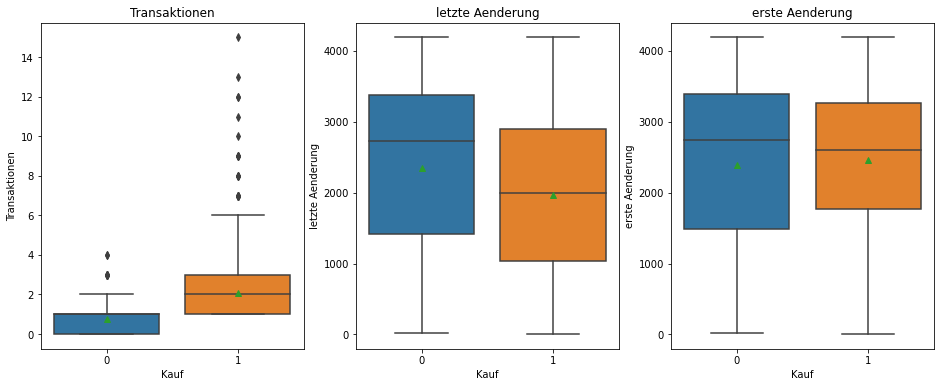

In [7]:
# Darstellung der Verteilung von Käufern & Nicht-Käufern anhand der kontinuierlichen Variablen in Boxplots
# Grüne Markierungen sind arithmetische Mittelwerte, Median ist duch schwarzen Querbalken markiert  

fig, axs = plt.subplots(1,3, figsize=(16,6))
pos = 0

for i in cont_var:
    sns.boxplot(df["Kauf"],df[i], showmeans=True, ax=axs[pos]).set_title(i)
    pos += 1


* **Transaktionen:** Käufer hatten im letzten Jahr mehr Transaktionen als Nicht-Käufer, im Durchschnitt haben Käufer zwei Käufe getätigt
* **Letzte Änderung:** Insgesamt aktivere Kunden sind tendetiell eher Käufer &rarr; weniger Tage seit letzter Änd. am Kundendatensatz spricht für Kauf; liegt die letzte Änderung                          länger zurück, scheint dies eher gegen einen Kauf zu sprechen
* **Erste Änderung:** Es scheint keinen wesentlichen Unterschied zu geben zwischen Käufern und Nicht-Käufern &rarr; Neukunden wie auch ältere Bestandskunden der verschiedenen Quellen neigen gleichermaßen zum Kauf bei Katalonia

         
**&rarr; Transaktionen und letzte Aenderung scheinen einen erkennbaren Einfuss auf die Zielvariable "Kauf" zu haben**

#### Kategorische Variablen

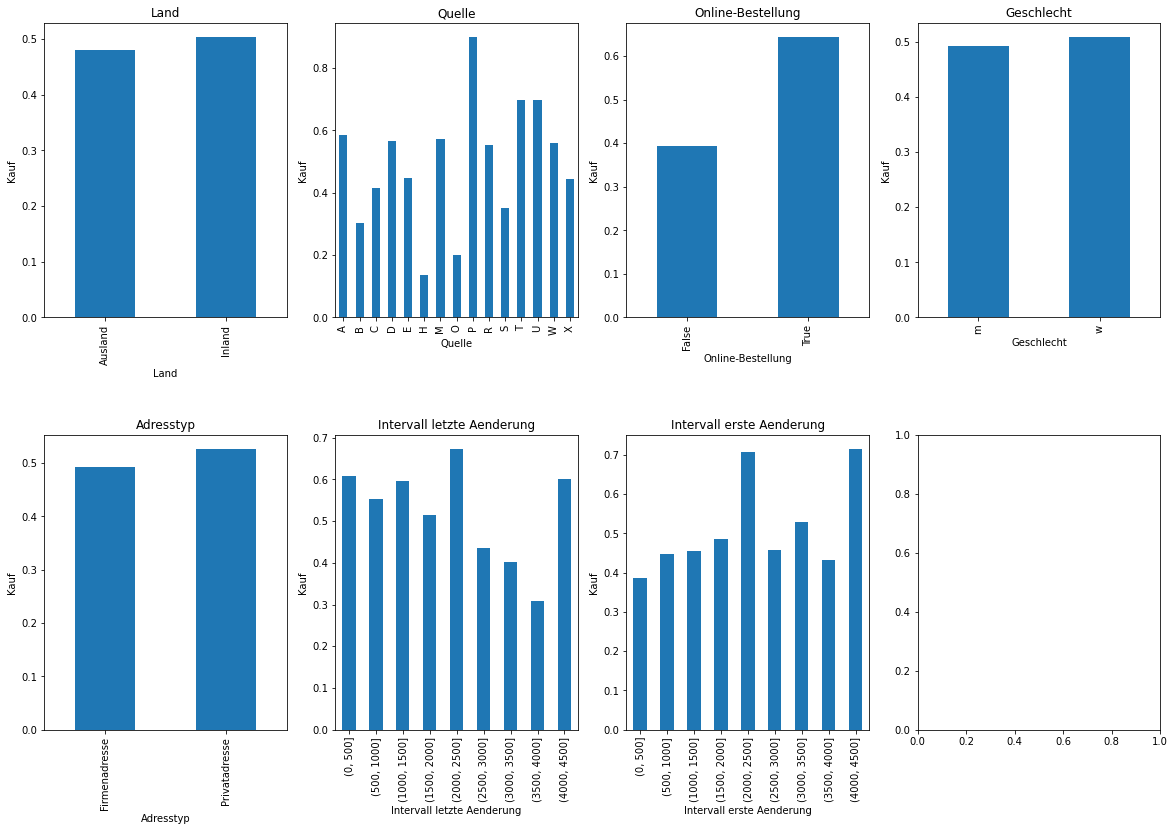

In [8]:
# Darstellung der Verteilung von Käufern & Nicht-Käufern anhand der kategorischen Variablen in Boxplots

fig, axs = plt.subplots(2,4, figsize=(20,13))
axs=axs.flatten()
plt.subplots_adjust(hspace=0.4)
pos = 0


for i in cat_var:
    df.groupby(i)["Kauf"].mean().plot(kind="bar", ax=axs[pos])
    axs[pos].set_xlabel(str(i))
    axs[pos].set_ylabel("Kauf")
    axs[pos].set_title(str(i))
    pos += 1

* **Inland:** Kaufwahrscheinlichkeit scheint im Inland leicht höher, aber kaum erheblich, vermutlich nicht signifikant
* **Quelle:** Kunden aus Quelle "P" scheinen eine sehr hohe Kaufwahrscheinlichkeit zu haben, gefolgt von Quellen "U" und "T". Die Quellen "H", "O" und "B" scheinen am deutlichsten gegen einen Kauf zu sprechen. 
* **Online-Bestellung:** Ca. 65% der ursprünglichen Onlinekäufer tätigten einen Kauf, jedoch nur ca. 40% der Nicht-Onlinekäufer &rarr; Variable scheint die Kaufwahrscheinlichkeit zu beeinflussen 
* **Geschlecht:** Es scheint kaum einen Unterschied zwischen den Geschlechtern zu geben. Die Kaufwahrscheinlichkeit ist jedoch bei Frauen unerheblich höher
* **Adresstyp:** Auch der Adresstyp scheint kaum einen Einfluss auf die Kaufwahrscheinlichkeit zu haben, wobei diese bei Privatadressen leicht höher ist, als bei Firmenadressen
* **letzte Änderung (Intervalle):** In den Intervallen der letzten Datensatzänderung lassen sich keine eindeutigen Tendenzen feststellen (Grundsätzlich negativer Trend, aber mit deutlichen Ausreißern)
* **erste Änderung (Intervalle):** In den Intervallen der ersten Datensatzänderung lassen sich keine eindeutigen Tendenzen feststellen, Variable scheint eher irrelevant

**&rarr; Quelle und Online-Bestellung scheinen den deutlichsten Einfuss auf die Zielvariable "Kauf" zu haben**

#### 2.3.2 Zielvariable: Umsatz

#### Kontinuierliche Variablen

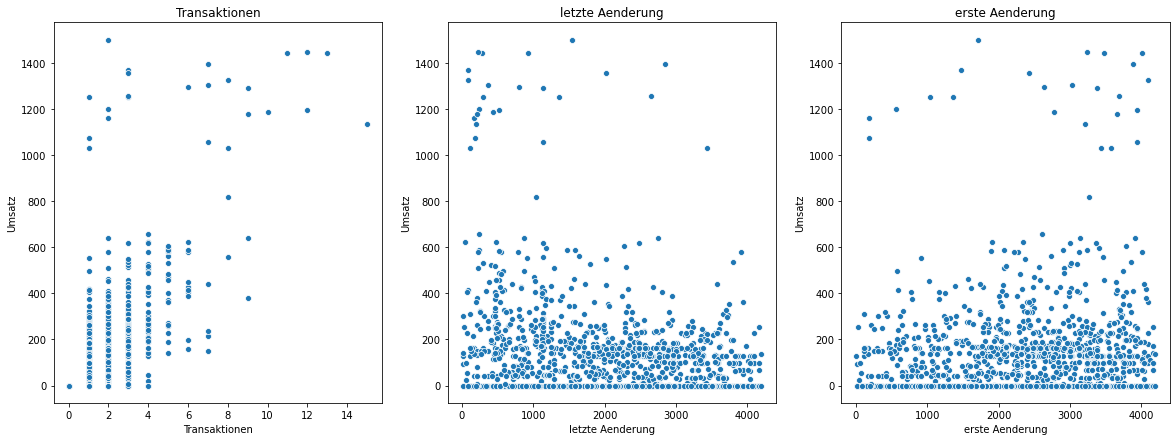

In [9]:
# Darstellung der Umsatzverteilung anhand der kontinuierlichen Variablen in Scatterplots

fig, axs = plt.subplots(1,3, figsize=(20,7))
pos = 0

for i in cont_var: 
    sns.scatterplot(df[i], df["Umsatz"], ax=axs[pos]).set_title(i)
    pos += 1

* **Transaktionen:** Auf den ersten Blick scheint ein positiver Zusammenhang zwischen Transaktionen und Umsatz zu bestehen; ein Großteil der Beobachtungen liegt jedoch im Bereich von 1-4 Transaktionen und einem eher geringen Umsatz (bis ca. 500€)
* **Letzte Änderung:** Es scheint keinen deutlichen Zusammenhang zwischen letzen Änderungen und dem Umsatz zu geben
* **Erste Änderung:** Es scheint keinen deutlichen Zusammenhang zwischen ersten Änderungen und dem Umsatz zu geben

         
**&rarr; die Variable Transaktionen scheint einen Einfuss auf die Zielvariable "Umsatz" zu haben**

#### Kategorische Variablen

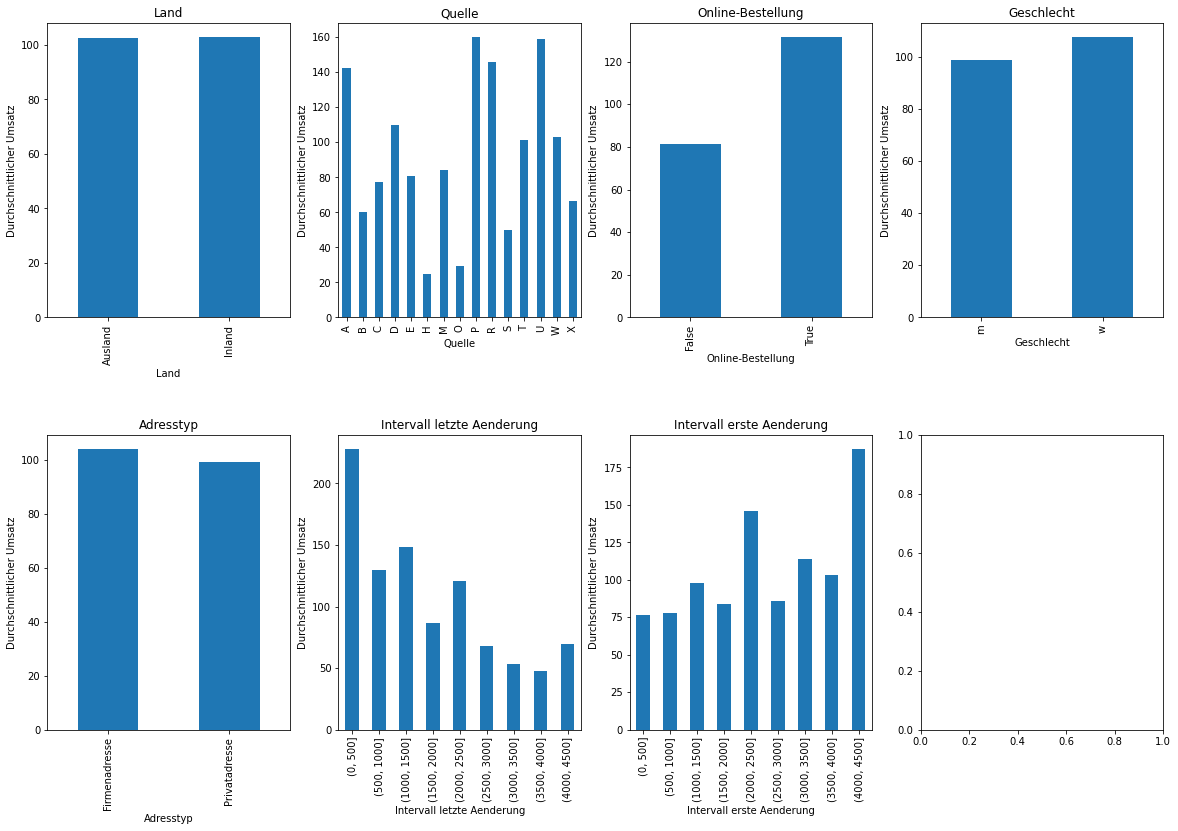

In [10]:
# Darstellung des durchschnittlichen Umsatzes anhand der kategorischen Variablen

fig, axs = plt.subplots(2,4, figsize=(20,13))
axs=axs.flatten()
plt.subplots_adjust(hspace=0.4)
pos = 0


for i in cat_var:
    df.groupby(i)["Umsatz"].mean().plot(kind="bar", ax=axs[pos])
    axs[pos].set_xlabel(str(i))
    axs[pos].set_ylabel("Durchschnittlicher Umsatz")
    axs[pos].set_title(str(i))
    pos += 1

* **Inland:** Inländische und ausländische Käufer haben im Schnitt Käufe in ähnlicher Höhe getätigt 
* **Quelle:** Die höchsten durchschnittlichen Umsätze erzielen die Quellen "P", "U", "R" und "A". Die niedrigsten durchschnittlichen Umsätze liegen bei den Quellen "H", "O" und "S".
* **Online-Bestellung:** Der durchschnittliche Umsatz bei Online-Bestellungen ist höher als bei Offline-Bestellungen 
* **Geschlecht:** Bei Frauen scheint der durchschnittliche Umsatz minimal höher als bei Männern
* **Adresstyp:** Der durchschnittliche Umsatz scheint bei Firmenadressen minimal höher zu sein als bei Privatadressen
* **letzte Änderung (Intervalle):** Es zeigt sich, dass "aktive" Käufer (= letzte Änderung <500 Tage / knapp 1,5 Jahre her) zu höheren Umsätzen tendieren; Trend: je länger die letzte Änderung her ist, desto geringer der generierte Umsatz
* **erste Änderung (Intervalle):** Es zeigt sich, dass langfristige Bestandskunden (= erste Änderung >4000 Tage / ca. 11 Jahre) zu höheren Umsätzen tendieren; sonst kein eindeutiger Trend zu erkennen

**&rarr; Quelle , Online-Bestellung und letzte Änderung scheinen den deutlichsten Einfuss auf die Zielvariable "Umsatz" zu haben**

#### 2.3.3 Heatmap Korrelation für alle Variablen

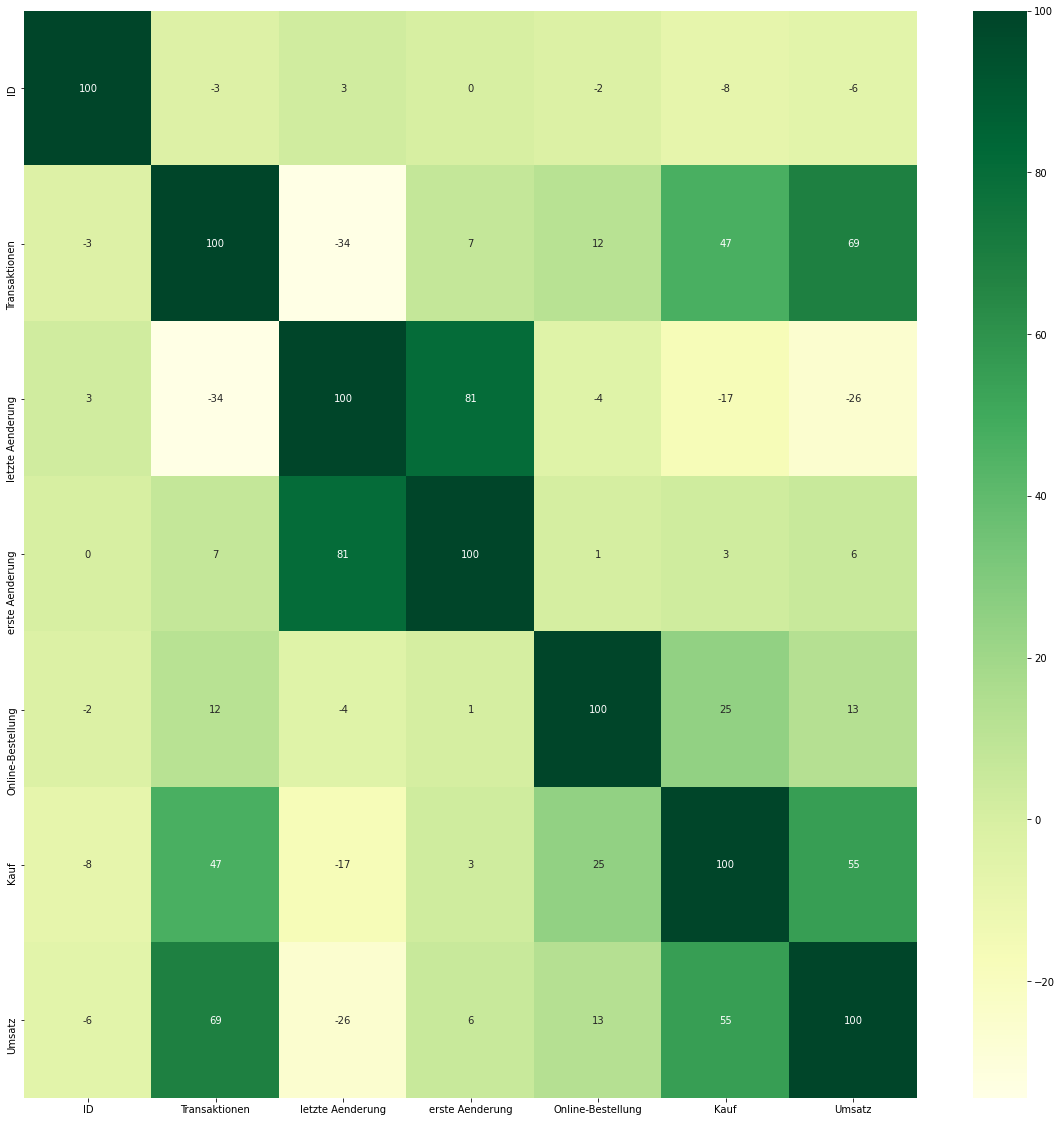

In [11]:
# Korrelation zwischen numerischen Werten des Dataframes
# Zwecks besserer Darstellung multipliziert mit 100 --> 69 = Korrelation von 0.69

fig, ax = plt.subplots(figsize=(20, 20))
corr = df.corr()
ax = sns.heatmap(corr*100, cmap="YlGn", annot= True, fmt=".0f")
plt.show()

**Besonders starke Korrelationen bei folgenden Variablen:**
* Transaktionen und Umsatz (positiv) : Je häufiger ein Kunde in der Vergangeheit gekauft hat, desto höher waren die Umsätze bei Katalonia im Testmailing
* Transaktionen und Kauf (positiv) : Je häufiger ein Kunde in der Vergangeheit gekauft hat, desto höher war die Kaufwahrscheinlichkeit im Testmailing von Katalonia
* Letzte Änderung und erste Änderung : Langfristige Bestandskunden (hohes erstes Änderungsdatum) haben zuletzt weniger Käufe getätigt (hohes letztes Änderungsdatum). Mögliche Erklärung: "Karteileichen". 

#### 2.3.4 Entropie und Information Gain

#### Funktionen für Entropie, Information Gain und besten Threshold definieren

In [12]:
# Entropie
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()  
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

# Information Gain
def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 

# Bester Threshold
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    l = []

    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
        
        l.append([thresh, IG])
    return (maximum_threshold, maximum_ig, l)

# Bester Split
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""
    l = []
    
    for info_column in info_columns:
        thresh, ig, x = best_threshold(df, info_column, target_column, criteria)
                       
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column          
        
        l.append([info_column, ig])
    return maximum_column, maximum_threshold, maximum_ig, l

#### Variable mit höchsten Information Gain (bzw. bestem Split im Decision Tree) finden

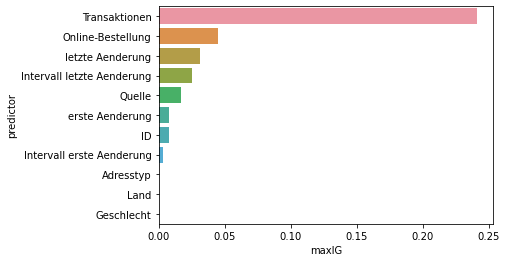

In [13]:
attributes=list(df.columns.values) # Liste aller Werte (je Spalte) erstellen
target_var= "Kauf"
attributes.remove("Kauf") #entfernen, da Zielvariable
attributes.remove("Umsatz")

max_col, max_threshold, max_ig, list_ig= best_split(df, attributes, target_var)

df_plot= pd.DataFrame(list_ig, columns=["predictor", "maxIG"])
df_plot.sort_values(by="maxIG", ascending=False, inplace=True)
sns.barplot(y="predictor", x="maxIG", data=df_plot)
plt.show()

### 2.4 Variablen und Datensätze für das weitere Vorgehen final kodieren

In [14]:
# Ersetze Inland und Ausland gegen 1 (Inland) und 0 (Ausland)
df["Land"].replace("Inland", 1, inplace=True)
df["Land"].replace("Ausland", 0, inplace=True)

# Ersetze Online-Bestellung gegen 1 (Online) und 0 (Offline)
df.loc[df["Online-Bestellung"] == True, "Online-Bestellung"] = 1
df.loc[df["Online-Bestellung"] == False, "Online-Bestellung"] = 0
df["Online-Bestellung"] = df["Online-Bestellung"].astype(int)
             
# Ersetze Geschlechter gegen 1 (weiblich) und 0 (männlich)
df["Geschlecht"].replace("w", 1, inplace=True)
df["Geschlecht"].replace("m", 0, inplace=True)

# Ersetzte Adresstypen gegen 1 (f. Privatadresse) und 0 (f. Firmenadresse)
df["Adresstyp"].replace("Privatadresse", 1, inplace=True)
df["Adresstyp"].replace("Firmenadresse", 0, inplace=True)

# Benenne Variablen um, damit Inhalt eindeutiger zu machen
df = df.rename(columns={'Land': 'Inland', 'Geschlecht': 'Weiblich', 'Adresstyp': 'Privatadresse'})

# Definiere Datensatz ohne Dummies (also ohne One Hot Encoding)
df_nodummy = df

# Definiere Datensatz mit Dummies (also mit One Hot Encoding für "Quelle")
df_dummy = pd.get_dummies(df, columns=['Quelle']) 

# Ersetzte Quellen im Datensatz ohne Dummies gegen numerische Werte (Quelle A =1, B=2 usw.)
code = 1
for i in sorted(sorted(df_nodummy["Quelle"].unique())):
    df_nodummy["Quelle"].replace(to_replace = i, value = code, inplace = True)
    code += 1 

In [15]:
# Ausgabe der Dataframes für die Dummy Variante. Zur besseren (vollständigen) Darstellung Achsen vertauscht. 

display((df_dummy.head(20)).T)
display((df_dummy.describe()).T) # Kurzauswertung zu Mittelwerten, Quartilen, etc.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ID,251,83,1002,108,206,1819,675,1371,1920,417,12,1843,1767,680,1539,1987,1924,218,1859,1281
Inland,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1
Transaktionen,0,0,1,1,0,1,2,2,3,2,2,1,1,1,1,4,1,1,0,1
letzte Aenderung,3507,3745,3242,2907,181,2975,1346,1920,2296,1346,1275,3436,2905,3397,3024,1710,2681,833,2172,216
erste Aenderung,3507,3745,3242,2907,181,2975,1386,1942,2564,1386,1313,3436,2905,3397,3024,2982,2681,833,2172,216
Online-Bestellung,0,1,0,0,0,1,0,1,1,0,0,1,1,1,1,0,1,0,0,0
Weiblich,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1,0,1,0,1
Privatadresse,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1
Kauf,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0
Umsatz,0,0,0,160,0,0,0,130,514,0,0,0,0,0,129,145,0,0,0,0


,count,mean,std,min,25%,50%,75%,max
ID,1700.0,1000.635294,576.492801,1.0,501.50,998.5,1492.25,2000.0
Inland,1700.0,0.825294,0.379827,0.0,1.00,1.0,1.00,1.0
Transaktionen,1700.0,1.408824,1.412312,0.0,1.00,1.0,2.00,15.0
letzte Aenderung,1700.0,2153.587647,1136.418689,7.0,1134.75,2284.0,3125.00,4188.0
erste Aenderung,1700.0,2428.418235,1079.679228,7.0,1650.75,2705.0,3340.00,4188.0
Online-Bestellung,1700.0,0.424706,0.494444,0.0,0.00,0.0,1.00,1.0
Weiblich,1700.0,0.477647,0.499647,0.0,0.00,0.0,1.00,1.0
Privatadresse,1700.0,0.225882,0.418285,0.0,0.00,0.0,0.00,1.0
Kauf,1700.0,0.500000,0.500147,0.0,0.00,0.5,1.00,1.0
Umsatz,1700.0,102.799412,186.700322,0.0,0.00,2.0,153.00,1500.0


In [16]:
# Ausgabe der Dataframes für die Nodummy Variante. 

display((df_nodummy.head(20)))
display(df_nodummy.describe()) # Kurzauswertung zu Mittelwerten, Quartilen, etc.

,ID,Inland,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse,Kauf,Umsatz,Intervall letzte Aenderung,Intervall erste Aenderung
0,251,1,1,0,3507,3507,0,1,0,0,0,"(3500, 4000]","(3500, 4000]"
1,83,1,8,0,3745,3745,1,1,0,0,0,"(3500, 4000]","(3500, 4000]"
2,1002,1,12,1,3242,3242,0,1,0,0,0,"(3000, 3500]","(3000, 3500]"
3,108,1,13,1,2907,2907,0,0,0,1,160,"(2500, 3000]","(2500, 3000]"
4,206,1,11,0,181,181,0,1,0,0,0,"(0, 500]","(0, 500]"
5,1819,0,5,1,2975,2975,1,1,0,0,0,"(2500, 3000]","(2500, 3000]"
6,675,1,6,2,1346,1386,0,0,1,0,0,"(1000, 1500]","(1000, 1500]"
7,1371,1,14,2,1920,1942,1,0,1,1,130,"(1500, 2000]","(1500, 2000]"
8,1920,0,5,3,2296,2564,1,1,0,1,514,"(2000, 2500]","(2500, 3000]"
9,417,1,6,2,1346,1386,0,1,1,0,0,"(1000, 1500]","(1000, 1500]"


,ID,Inland,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse,Kauf,Umsatz
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,1000.635294,0.825294,7.341176,1.408824,2153.587647,2428.418235,0.424706,0.477647,0.225882,0.500000,102.799412
std,576.492801,0.379827,4.865230,1.412312,1136.418689,1079.679228,0.494444,0.499647,0.418285,0.500147,186.700322
min,1.000000,0.000000,1.000000,0.000000,7.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,501.500000,1.000000,3.000000,1.000000,1134.750000,1650.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,998.500000,1.000000,6.000000,1.000000,2284.000000,2705.000000,0.000000,0.000000,0.000000,0.500000,2.000000
75%,1492.250000,1.000000,13.000000,2.000000,3125.000000,3340.000000,1.000000,1.000000,0.000000,1.000000,153.000000
max,2000.000000,1.000000,15.000000,15.000000,4188.000000,4188.000000,1.000000,1.000000,1.000000,1.000000,1500.000000


#### Finale Sortierung für das weitere Vorgehen

In [17]:
# Erneute Sortierung für die weitere Darstellung, da in der oberen Zuordnung für die Darstellung, die Variablen letzte &
# erste Änderung sowohl als kontinuierliche als auch als kategorische Variablen hinterlegt sind. Außerdem fehlt in obiger
# Darstellung noch die Unterteilung in die Dummy & Nodummy Variante 

target_kauf = "Kauf"
target_umsatz = "Umsatz"
cat_var = ["Inland", "Online-Bestellung", "Weiblich", "Privatadresse", "Quelle_A", "Quelle_B", "Quelle_C",
          "Quelle_D", "Quelle_E", "Quelle_H", "Quelle_M", "Quelle_O", "Quelle_P", "Quelle_R", "Quelle_S", "Quelle_T",
          "Quelle_U", "Quelle_W", "Quelle_X"]
cont_var = ["Transaktionen", "letzte Aenderung", "erste Aenderung"] 
expl_var_dummy = cat_var + cont_var
expl_var_nodummy = ["Inland", "Online-Bestellung", "Weiblich", "Privatadresse", "Quelle"] + cont_var

## Gesamtzusammenfassung der Data Preparation und Visualisierung

### Datenbasis 

**Ausgangsdaten**
- Ausgangsdaten bieten wegen fehlender Kodierung nur wenig direkt verarbeitbare Informationen 
- Insgesamt umfasst der Datensatz 1700 Datensätze aus 15 verschiedenen Quellen
- Der durchschnittliche Umsatz liegt bei ca. 102,8[€] 

**Kodierte Daten**
- Bei 0/1 Kodierung stellt der Mittelwert auch die prozentuale Häufigkeit eines Wertes dar
- 82,5% der Daten stammen von Kunden aus dem Inland
- Der Großteil der Kunden hat im vergangenen Jahr eine Transaktion getätigt [Median], der Mittelwert liegt bei 1,4 Transaktionen
- Das Alter der Datensätze (erste sowie letzte Änderung) ist gleichmäßig über verschiedene Jahre verteilt [siehe Minimal-Wert, Maximal-Wert & Quartile in Tabelle oben]
- 42,5% der Kunden sind potentiell gute Zielkunden, da diese mindestens einmal einen Onlinekauf getätigt haben
- Frauen & Männer sind relativ gleichverteilt (Anteil Frauen 47,8%)
- Firmenadressen sind deutlich überrepräsentiert (77,4%)
- Oversampling von Käufern (Anteil von 50% innerhalb der Daten), tatsächlicher Anteil an Käufern auf alle Sendungen jedoch deutlich geringer
- Umsätze weisen eine starke Standardabweichung auf, Umsatzprognose dürfte dadurch erschwert werden
- Einzelne Quellen sind sehr dominant vertreten (A, E, U, W jeweils >10%), andere sehr viel seltener vertreten

### Einflüsse auf die Zielvariable "Kauf" 

**Transaktionen**
- Käufer hatten im Schnitt mehr Transaktionen im letzten Jahr als Nicht-Käufer
- Der Großteil der Käufer hat im vorherigen Jahr zwei Transatktionen getätigt (Median=2), der Großteil der Nicht-Käufer eine Transaktion
- Der größte Ausreißer der vorherigen Transaktionen bei Nicht-Käufern liegt bei 4, d.h. Kunden mit fünf vorherigen Transaktionen sind Käufer

**Letzte Änderung**
- Im Mittel liegt die letzte Änderung der Datensätze bei Nicht-Käufern länger zurück als bei Käufern
- Aufgrund der sehr hohen Streuung ist die Aussagekraft dieser Variable fraglich
- Auch in der alternativen Darstellung in gleichgroßen Klassen lassen nur leicht negative Korrelationen vermuten

**Erste Änderung**
- Die Betrachung der ersten Änderung liefert keinen nennenswerten Unterschied zwischen Käufern & Nicht-Käufern
- Auch in der alternativen Darstellung in gleichgroßen Klassen lassen sich keine Trends feststellen

**Inland/Ausland**
- Unter inländischen Kunden war die Kaufwahrscheinlichkeit minimal höher
- Vermutlich jedoch ein eher zufälliger Effekt 

**Quellen**
- Kunden der Quellen P, U & T (bzw. 9, 12 & 13 nach Kodierung) haben am häufigsten auch einen Kauf bei Katalonia getätigt 
- Kunden der Quellen B, H, O, S (bzw. 2, 6, 8 & 11 nach Kodierung) haben eher selten auch einen Kauf bei Katalonia getätigt
- Mögliche Interpretation ist, dass die Quellen P, U & T sehr ähnliche Shops wie Katalonia sind oder zumindest aufgrund ihres Produktporfolios ähnliche Kundengruppen adressieren 

**Online/Offlinekäufer**
- Ca. 65% der Kunden, die bereits vorher mindestens einen Kauf online getätigt haben, haben einen Kauf bei Katalonia getätigt
- Im Vergleich dazu lag die Käuferquote bei Kunden, die vorher keinerlei Aktivitäten im Onlineshopping hatten, bei ca. 40% 

**Geschlecht**
- Bei Kundinnen war die Kaufwahrscheinlichkeit lediglich minimal höher

**Adresstyp**
- Bei Privatadressen war die Kaufwahrscheinlichkeit lediglich minimal höher

#### &rarr; Transaktionen, letzte Änderung, Quelle und Online Bestellung als primäre Einflussfaktoren 

###  Einflüsse auf die Zielvariable "Umsatz" 


**Transaktionen**
- Regelmäßige Käufer mit 5 oder mehr Transaktionen im vergangenen Jahr neigen zu Umsätzen über dem Mittelwert bei Katalonia


**Letzte Änderung**
- Die Datenbasis verteilt sich recht gleichmäßig zwischen "aktuellen" Datensätzen, die vor kurzem zuletzt geändert wurden und nicht-aktuellen Datensätzen mit einem Maximalalter von >4.000 Tagen
- Auf den ersten Blick (Scatterplot) besteht kein direkter Zusammehang zum erwirtschafteten Umsatz
- Es zeigt sich jedoch, dass Ausreißer mit besonders hohem Umsatz in den aktuelleren Datensätzen liegen
- Bei der alternativen Darstellung in Intervallen zeigt sich, dass inbesondere Datensätze mit einem letzten Änderungsdatum bis 500 einen im Schnitt höheren Umsatz generieren
- Im Gesamttrend sinken die Umsätze in den folgenden Intervallen kontinuierlich, jedoch unterbrochen von Ausreißern in den Intervallen 1000-1500 sowie 2000-2500


**Erste Änderung**
- Die Datenbasis verteilt sich recht gleichmäßig zwischen  neuen Bestandskunden, die kürzlich erstmalig geändert wurden und alten Bestandskunden  
- Auf den ersten Blick (Scatterplot) besteht kein direkter Zusammehang zum erwirtschafteten Umsatz
- Es zeigt sich jedoch, dass Ausreißer mit besonders hohem Umsatz eher in den alten Bestandskunden liegen
- Auch die alternative Darstellung in Intervallen zeigt keinen eindeutigen Trend. Die alten Bestandskunden (erste Änderung >4000 Tage) haben die im Schnitt höchsten Umsätze, weitere Trends sind jedoch nicht zu erkennen  


**Inland/Ausland**
- Die Umsätze sind bei Kunden im Inland & Ausland nahezu identisch

**Quellen** 
- Umsätze sind bei Kunden aus den Quellen A, P, R & U (bzw. 1, 9, 10, 13 nach Kodierung) im Schnitt besonders hoch
- Umsätze sind bei Kunden aus den Quellen H, O, S (bzw. 6, 8, 11 nach Kodierung) im Schnitt besonders niedrig 


**Online/Offlinekäufer**
- Onlinekäufer generieren im Schnitt deutlich höhere Umsätze 

**Geschlecht**
- Kundinnen erwirtschafteten im Schnitt einen minimal höheren Umsatz

**Adresstyp**
- Bei Firmenadressen waren die durchschnittlichen Umsätze minimal erhöht


#### &rarr;  Quelle, Online Bestellung, Transaktionen und letzte Änderung scheinen den deutlichsten Einfluss auf die Zielvariable "Umsatz" zu haben



## 3. Klassifizierungsmodelle

### Split in Test- & Trainingsdaten

In [18]:
# Definiere X und Y für dummy / no dummy
X_dummy_class = df_dummy[expl_var_dummy]
Y_dummy_class = df_dummy[target_kauf]
X_nodummy_class = df_nodummy[expl_var_nodummy]
Y_nodummy_class = df_nodummy[target_kauf]

# Split in Test- und Trainingsdaten für Dummy-Satz und No-Dummy-Satz
x_train_dummy_class, x_test_dummy_class, y_train_dummy_class, y_test_dummy_class = train_test_split(X_dummy_class, Y_dummy_class, random_state = 42)
x_train_nodummy_class, x_test_nodummy_class, y_train_nodummy_class, y_test_nodummy_class = train_test_split(X_nodummy_class, Y_nodummy_class, random_state = 42)

pd.options.display.max_columns = None
display(df_dummy.head(10))
display(df_nodummy.head(10))


,ID,Inland,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse,Kauf,Umsatz,Intervall letzte Aenderung,Intervall erste Aenderung,Quelle_A,Quelle_B,Quelle_C,Quelle_D,Quelle_E,Quelle_H,Quelle_M,Quelle_O,Quelle_P,Quelle_R,Quelle_S,Quelle_T,Quelle_U,Quelle_W,Quelle_X
0,251,1,0,3507,3507,0,1,0,0,0,"(3500, 4000]","(3500, 4000]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,83,1,0,3745,3745,1,1,0,0,0,"(3500, 4000]","(3500, 4000]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1002,1,1,3242,3242,0,1,0,0,0,"(3000, 3500]","(3000, 3500]",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,108,1,1,2907,2907,0,0,0,1,160,"(2500, 3000]","(2500, 3000]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,206,1,0,181,181,0,1,0,0,0,"(0, 500]","(0, 500]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,1819,0,1,2975,2975,1,1,0,0,0,"(2500, 3000]","(2500, 3000]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,675,1,2,1346,1386,0,0,1,0,0,"(1000, 1500]","(1000, 1500]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,1371,1,2,1920,1942,1,0,1,1,130,"(1500, 2000]","(1500, 2000]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,1920,0,3,2296,2564,1,1,0,1,514,"(2000, 2500]","(2500, 3000]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,417,1,2,1346,1386,0,1,1,0,0,"(1000, 1500]","(1000, 1500]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


,ID,Inland,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse,Kauf,Umsatz,Intervall letzte Aenderung,Intervall erste Aenderung
0,251,1,1,0,3507,3507,0,1,0,0,0,"(3500, 4000]","(3500, 4000]"
1,83,1,8,0,3745,3745,1,1,0,0,0,"(3500, 4000]","(3500, 4000]"
2,1002,1,12,1,3242,3242,0,1,0,0,0,"(3000, 3500]","(3000, 3500]"
3,108,1,13,1,2907,2907,0,0,0,1,160,"(2500, 3000]","(2500, 3000]"
4,206,1,11,0,181,181,0,1,0,0,0,"(0, 500]","(0, 500]"
5,1819,0,5,1,2975,2975,1,1,0,0,0,"(2500, 3000]","(2500, 3000]"
6,675,1,6,2,1346,1386,0,0,1,0,0,"(1000, 1500]","(1000, 1500]"
7,1371,1,14,2,1920,1942,1,0,1,1,130,"(1500, 2000]","(1500, 2000]"
8,1920,0,5,3,2296,2564,1,1,0,1,514,"(2000, 2500]","(2500, 3000]"
9,417,1,6,2,1346,1386,0,1,1,0,0,"(1000, 1500]","(1000, 1500]"


### 3.1 Logistische Regression

#### Test auf optimale Variablenkombination

Es wird getested, welche Kombination von Variablen die höchste Modellgüte erzielt. Um den Rechenaufwand klein zu halten, wird dies nur für den Datensatz ohne Dummy-Variablen durchgeführt.

In [19]:
# Definiere Powerset-Funktion mit dem alle Sub-Sets eines Datensets ermittelt werden
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

iterable = ["1", "2", "3"]

print(list(powerset(iterable)))

[(), ('1',), ('2',), ('3',), ('1', '2'), ('1', '3'), ('2', '3'), ('1', '2', '3')]


In [20]:
# Definiere Funktion für Variablen-Kombinationen
def prepare_feature_combinations(feature_combinations):

    feature_list = []

    for fc in feature_combinations[1:]:
        flattend = []

        for item in fc:
            if type(item) is list:
                flattend.extend(item)
            else:
                flattend.extend([item])

        feature_list.append(flattend)

    return feature_list

In [21]:
# Berechnung der Scores der log. reg. für sämtliche mögliche Kombinationen

feature_list = ["Quelle", "Transaktionen", "letzte Aenderung", "erste Aenderung", "Online-Bestellung", 
               "Weiblich", "Privatadresse", "Inland"]

feature_combinations = list(powerset(feature_list))
feature_combinations = prepare_feature_combinations(feature_combinations)

train_results = []
test_results = []

y = Y_nodummy_class

for i, fc in enumerate(feature_combinations):
      
    st = str("Compute features combination {}".format(i))
    print(st, end="\r", flush=True)
    
    # input features
    x = X_nodummy_class[fc]
    
    # split data
    X_train_logreg, X_test_logreg, Y_train_logreg, Y_test_logreg = train_test_split(x,y, random_state=42)
    
    # model für log. reg.
    LogReg = LogisticRegression(n_jobs=-1, random_state=42)

    # train
    LogReg.fit(X_train_logreg, Y_train_logreg)
    
    # log. reg. results
    train_results.append(LogReg.score(X_train_logreg, Y_train_logreg))
    test_results.append(LogReg.score(X_test_logreg, Y_test_logreg))

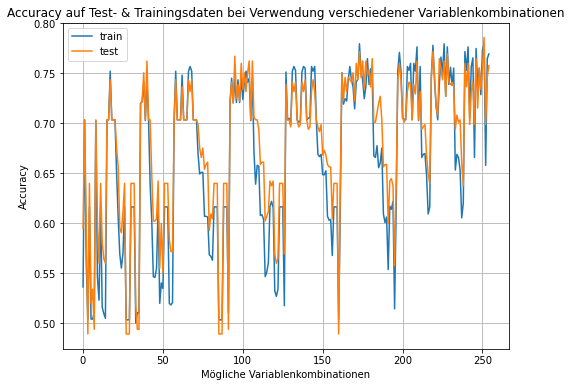

In [22]:
# graphische Darstellung der Accuracy auf Test- Trainingsdaten zur Ermittlung der optimalen Kombination

fig = plt.figure(figsize=(8, 6))
plt.plot(train_results, label="train")
plt.plot(test_results, label="test")
plt.legend()
plt.xlabel("Mögliche Variablenkombinationen")
plt.ylabel("Accuracy")
plt.title("Accuracy auf Test- & Trainingsdaten bei Verwendung verschiedener Variablenkombinationen")
plt.grid()

In [23]:
# Ausgabe der besten Variablen-Kombination

best_combination_id = np.where((np.array(test_results) > 0.79))    # ungefährer Wert aus Darstellung oben abgelesen
for bci in best_combination_id[0]:
    print("fc: {} | res: {}".format(feature_combinations[bci], test_results[bci]))

Das beste Ergebnis wird mit folgenden erklärenden Variablen erzielt: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Privatadresse', 'Inland']. Es wird also nur "Online-Bestellung" und "Weiblich" ausgeschlossen.
Im folgenden werden nun drei Versionen getestet:
* Logistische Regression mit allen Dummy Variablen
* Logistische Regression mit den ausgewählten Dummy Variablen (aus dem Test ohne Dummies)
* Logistische Regression mit den ausgewählten Variablen ohne Dummies

#### Erklärende Variablen festlegen

In [24]:
# Für die Dummy und No-Dummy Variante werden "Online-Bestellung" und "Weiblich" als erklärende Variablen ausgeschlossen 

expl_var_logreg_nodummy = ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Privatadresse', 'Inland']

expl_var_logreg_dummy = ['Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Privatadresse', 'Inland', "Quelle_A", 
                         "Quelle_B", "Quelle_C", "Quelle_D", "Quelle_E", "Quelle_H", "Quelle_M", "Quelle_O", "Quelle_P", 
                         "Quelle_R", "Quelle_S", "Quelle_T", "Quelle_U", "Quelle_W", "Quelle_X"]

#### No parameter optimization test/train (alle Variablen, aus Dataframe mit Dummies)

In [25]:
LogReg = LogisticRegression(n_jobs=-1, random_state=42).fit(x_train_dummy_class, y_train_dummy_class)

print('logistic regression coeff (w): {}'
     .format(LogReg.coef_))
print('Score (training): {:.3f}'
     .format(LogReg.score(x_train_dummy_class, y_train_dummy_class)))
print('Score (test): {:.3f}'
     .format(LogReg.score(x_test_dummy_class, y_test_dummy_class)))

logistic regression coeff (w): [[ 4.83582777e-02  7.03950011e-01  2.14828371e-01 -1.15769521e+00
   4.50491876e-01 -6.31318038e-01 -7.94768646e-01 -2.69292284e-02
   6.22396255e-02 -2.67993024e+00  3.87588311e-01 -2.91702154e-01
   1.37671634e-01  1.84156594e-01 -3.60822818e-01  2.52779811e-01
   9.01237014e-01  2.00635854e-02  1.28797917e-02  2.32405000e+00
  -6.32532416e-05 -1.14124565e-04]]
Score (training): 0.802
Score (test): 0.793


#### No parameter optimization test/train (ausgewählte Variablen, aus Dataframe mit Dummies)

In [26]:
LogReg = LogisticRegression(n_jobs=-1, random_state=42).fit(x_train_dummy_class[expl_var_logreg_dummy], y_train_dummy_class)

print('logistic regression coeff (w): {}'
     .format(LogReg.coef_))
print('Score (training): {:.3f}'
     .format(LogReg.score(x_train_dummy_class[expl_var_logreg_dummy], y_train_dummy_class)))
print('Score (test): {:.3f}'
     .format(LogReg.score(x_test_dummy_class[expl_var_logreg_dummy], y_test_dummy_class)))

logistic regression coeff (w): [[ 2.29864335e+00 -5.67346547e-05 -1.41690450e-04 -1.67571768e+00
  -1.08933255e-01  4.97742945e-01 -4.96614155e-01 -5.83813464e-01
   2.06637303e-02 -1.46929412e-01 -2.20498461e+00  2.46262088e-01
  -2.42012463e-01  1.08297255e-01  1.10458262e-01 -3.31979087e-01
   2.10128419e-01  1.03490519e+00 -1.33978474e-02  2.57996218e-02]]
Score (training): 0.791
Score (test): 0.791


#### No parameter optimization test/train (ausgewählte Variablen, aus Dataframe ohne Dummies)

In [27]:
LogReg = LogisticRegression(n_jobs=-1, random_state=42).fit(x_train_nodummy_class[expl_var_logreg_nodummy], 
                                                            y_train_nodummy_class)

print('logistic regression coeff (w): {}'
     .format(LogReg.coef_))
print('Score (training): {:.3f}'
     .format(LogReg.score(x_train_nodummy_class[expl_var_logreg_nodummy], y_train_nodummy_class)))
print('Score (test): {:.3f}'
     .format(LogReg.score(x_test_nodummy_class[expl_var_logreg_nodummy], y_test_nodummy_class)))

logistic regression coeff (w): [[ 3.76216896e-02  2.00194852e+00 -1.86100806e-04  1.78702909e-04
  -1.86154096e+00  6.36738547e-03]]
Score (training): 0.739
Score (test): 0.765


Die Ergebnisse unterscheiden sich kaum. Daher werden die Varianten "alle Dummies" und "ausgewählte no Dummies" in die Kreuzvalidierung miteingeschlossen, um verlässlichere Ergebnisse zu erlangen. Dabei soll außerdem geprüft werden, ob es sinnvoll ist, die Daten vor der Hyperparameter-Optimierung zu skalieren.

#### Cross validation without parameter optimization (not scaled) -> alle Variablen, Dummy Variante

In [28]:
cv = KFold(n_splits = 10)

LogReg = LogisticRegression(n_jobs=-1, random_state=42)
scores = cross_val_score(LogReg, X_dummy_class , Y_dummy_class, cv = cv)

print("Cross validation scores for logistic regression: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())

Cross validation scores for logistic regression: 
Scores:	:  [0.79411765 0.78235294 0.81764706 0.74705882 0.78823529 0.78235294
 0.84705882 0.80588235 0.80588235 0.78823529]
Mean:			 0.796
Std. deviation: 	 0.025


#### Cross validation without parameter optimization (scaled) -> alle Variablen, Dummy Variante

In [29]:
cv = KFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('LogReg', LogisticRegression(random_state=42))])

scores = cross_val_score(pipe, X_dummy_class , Y_dummy_class, cv = cv)

print("\nCross validation scores for logistic regression with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for logistic regression with pipeline: 
Scores:	:  [0.77647059 0.78235294 0.81176471 0.75294118 0.77647059 0.78823529
 0.82352941 0.79411765 0.76470588 0.77647059]
Mean:			 0.785
Std. deviation: 	 0.020


#### Cross validation without parameter optimization (not scaled) -> ausgewählte Variablen, ohne Dummies

In [30]:
cv = KFold(n_splits = 10)

LogReg = LogisticRegression(n_jobs=-1, random_state=42)
scores = cross_val_score(LogReg, X_nodummy_class[expl_var_logreg_nodummy] , Y_nodummy_class, cv = cv)

print("Cross validation scores for logistic regression: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())

Cross validation scores for logistic regression: 
Scores:	:  [0.73529412 0.69411765 0.79411765 0.7        0.71764706 0.75882353
 0.80588235 0.74117647 0.74117647 0.74705882]
Mean:			 0.744
Std. deviation: 	 0.034


#### Cross validation without parameter optimization (scaled) -> ausgewählte Variablen ohne Dummies

In [31]:
cv = KFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('LogReg', LogisticRegression(random_state=42))])

scores = cross_val_score(pipe, X_nodummy_class[expl_var_logreg_nodummy] , Y_nodummy_class, cv = cv)

print("\nCross validation scores for logistic regression with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for logistic regression with pipeline: 
Scores:	:  [0.75882353 0.75294118 0.80588235 0.72941176 0.73529412 0.74705882
 0.82941176 0.75882353 0.77058824 0.78823529]
Mean:			 0.768
Std. deviation: 	 0.030


Am besten schneidet die Variante mit den allen Dummy-Variablen und ohne Skalierung ab. Diese wird daher für die Hyperparameter-Optimierung verwendet.

#### Hyperparameter Optimierung (Test-Training)

In [32]:
cv = StratifiedKFold(n_splits = 10)
LogReg = LogisticRegression(n_jobs=-1).fit(x_train_dummy_class, y_train_dummy_class)
print("Accuracy without hyperparameter optimization:\t %.3f" % LogReg.score(x_test_dummy_class, y_test_dummy_class))

param_grid = [
    {'C': np.arange(start = 0.1, stop = 10, step=0.1)}
]

LogReg = LogisticRegression(n_jobs=-1, random_state=42)
search = GridSearchCV(estimator=LogReg, param_grid=param_grid, cv=cv, n_jobs=-1, 
                      scoring = ['accuracy', 'precision', 'f1', 'recall'], refit = 'accuracy')
search.fit(x_train_dummy_class, y_train_dummy_class)

print("\nResults of hyperparameter search on training-set")
print("Best accuracy:\t\t %.3f" % search.best_score_)
print("Best hyperparameters:\t %s" % search.best_params_)
print("Best estimator:\t\t %s" % search.best_estimator_)

best_logreg = search.best_estimator_
best_logreg.fit(x_train_dummy_class, y_train_dummy_class)
print("\nAccuracy on test-set with hyperparameter optimization:\t %.3f" % best_logreg.score(x_test_dummy_class, y_test_dummy_class))

Accuracy without hyperparameter optimization:	 0.793

Results of hyperparameter search on training-set
Best accuracy:		 0.806
Best hyperparameters:	 {'C': 5.0}
Best estimator:		 LogisticRegression(C=5.0, n_jobs=-1, random_state=42)

Accuracy on test-set with hyperparameter optimization:	 0.795


#### Betrachtung alternativer Gütemaße

In [33]:
df_results_gridsearch = pd.DataFrame(search.cv_results_)
print('\033[1m'"Best Accuracy:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_accuracy']<=5][['params', 'mean_test_accuracy','rank_test_accuracy']].sort_values(by = 'rank_test_accuracy', axis = 0))
print('\033[1m'"Best Precision:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_precision']<=5][['params', 'mean_test_precision','rank_test_precision']].sort_values(by = 'rank_test_precision', axis = 0))
print('\033[1m'"Best Recall:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_recall']<=5][['params', 'mean_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_recall', axis = 0))
print('\033[1m'"Best F1:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_f1']<=5][['params', 'mean_test_f1', 'rank_test_f1']].sort_values(by = 'rank_test_f1', axis = 0))

Best Accuracy:


,params,mean_test_accuracy,rank_test_accuracy
49,{'C': 5.0},0.805549,1
40,{'C': 4.1},0.803986,2
93,{'C': 9.4},0.803980,3
2,{'C': 0.30000000000000004},0.803974,4
83,{'C': 8.4},0.803211,5


Best Precision:


,params,mean_test_precision,rank_test_precision
49,{'C': 5.0},0.809559,1
50,{'C': 5.1},0.808028,2
35,{'C': 3.6},0.806913,3
12,{'C': 1.3000000000000003},0.806557,4
40,{'C': 4.1},0.806482,5


Best Recall:


,params,mean_test_recall,rank_test_recall
83,{'C': 8.4},0.811587,1
65,{'C': 6.6},0.808486,2
66,{'C': 6.7},0.806923,3
73,{'C': 7.4},0.806923,3
56,{'C': 5.7},0.806899,5


Best F1:


,params,mean_test_f1,rank_test_f1
49,{'C': 5.0},0.806378,1
83,{'C': 8.4},0.806141,2
93,{'C': 9.4},0.805564,3
40,{'C': 4.1},0.805533,4
2,{'C': 0.30000000000000004},0.805029,5


Hier zeigt sich, welche Parameter die beste Accuracy liefern. Diese werden aufgrund der Aufgabenstellung auch als beste Parameter gewertet.

Tatsächlich könnte es sinnvoll sein, nicht bzw. nicht nur die beste Accuracy [(True Positives + True Negatives) / Total population)] als Bewertungsmaßstab zu nutzen.

In diesem Fall wäre ggf. auch alterantiv/zusätzlich eine Betrachtung folgender Maße sinnvoll:

- Precision (Positive Predictive Value) = (True Positives / Predicted Condition Positive) - "Wie viele Kunden, die ich als "Käufer" klassifiziert habe, waren auch tatsächlich Käufer?"
- Recall (True Postive Rate) = (True Positives / Condition Positive) - "Wie viele tatsächliche Käufer habe ich auch richtig als "Käufer" klassifiziert?"
- F1 Score = 2* ((Precision * Recall) / (Precision + Recall)) als harmonisches Mittel aus Recall & Precision

#### Nested Cross Validation mit optimierten Parametern (um finale Accuracy zu bestimmen)

In [34]:
inner_cv = StratifiedKFold(n_splits = 10)
outer_cv = StratifiedKFold(n_splits = 10)

param_grid = [
  {'C': [8.6]}
]

LogReg = LogisticRegression(n_jobs=-1, random_state=42)
search = GridSearchCV(estimator=LogReg, param_grid=param_grid, cv=inner_cv)
scores_logreg =  cross_val_score(search, X_dummy_class, Y_dummy_class, cv=outer_cv)

print("Accuracy of logistic regression: ")
print("Mean:\t %.3f" % scores_logreg.mean())
print("Std:\t %.3f" % scores_logreg.std())

Accuracy of logistic regression: 
Mean:	 0.798
Std:	 0.032


**Finale Accuracy für die Logistische Regression liegt bie 79,9%**

### 3.2 Entscheidungsbaum

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> No Dummy-Variante

,Score test,Score train,Depth,Nodes
0,0.696471,0.705882,1,3
1,0.696471,0.705882,2,5
2,0.743529,0.752157,3,9
3,0.764706,0.774902,4,17
4,0.785882,0.797647,5,33
5,0.818824,0.814902,6,63
6,0.795294,0.829020,7,105
7,0.807059,0.853333,8,149
8,0.788235,0.870588,9,191
9,0.776471,0.899608,10,239


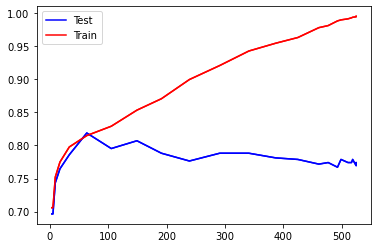

In [35]:
score_test = []
score_train = []
complexity = []
nodes = []

DecTree = DecisionTreeClassifier(random_state=42)
DecTree = DecTree.fit(x_train_nodummy_class, y_train_nodummy_class)

for i in range(1, DecTree.tree_.max_depth):
    DecTree = DecisionTreeClassifier(max_depth=i, random_state=42)
    DecTree = DecTree.fit(x_train_nodummy_class, y_train_nodummy_class)
    score_train.append(DecTree.score(x_train_nodummy_class, y_train_nodummy_class))
    score_test.append(DecTree.score(x_test_nodummy_class, y_test_nodummy_class))
    complexity.append(i)
    nodes.append(DecTree.tree_.node_count)
    
score_table_nodummy = pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity, "Nodes":nodes})

display(score_table_nodummy)

plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score test"], color="b")
plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score train"], color="r")

line1, = plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Optimale Baumtiefe ohne weitere Optimierungen: 6

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> Dummy-Variante

,Score test,Score train,Depth,Nodes
0,0.696471,0.705882,1,3
1,0.696471,0.705882,2,5
2,0.785882,0.781961,3,9
3,0.804706,0.800000,4,17
4,0.800000,0.810196,5,33
5,0.783529,0.818039,6,51
6,0.802353,0.828235,7,77
7,0.774118,0.847059,8,113
8,0.804706,0.866667,9,155
9,0.809412,0.890196,10,201


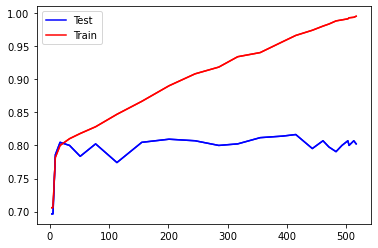

In [36]:
score_test = []
score_train = []
complexity = []
nodes = []

DecTree = DecisionTreeClassifier(random_state=42)
DecTree = DecTree.fit(x_train_dummy_class, y_train_dummy_class)

for i in range(1, DecTree.tree_.max_depth):
    DecTree = DecisionTreeClassifier(max_depth=i, random_state=42)
    DecTree = DecTree.fit(x_train_dummy_class, y_train_dummy_class)
    score_train.append(DecTree.score(x_train_dummy_class, y_train_dummy_class))
    score_test.append(DecTree.score(x_test_dummy_class, y_test_dummy_class))
    complexity.append(i)
    nodes.append(DecTree.tree_.node_count)
    
    
score_table_dummy= pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity, "Nodes":nodes})

display(score_table_dummy)

plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score test"], color="b")
plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score train"], color="r")

line1, = plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Optimale Baumtiefe ohne weitere Optimierungen: 16

#### Vergleich der Performance bei verschiedenen Baumtiefen: Dummy vs. no Dummy

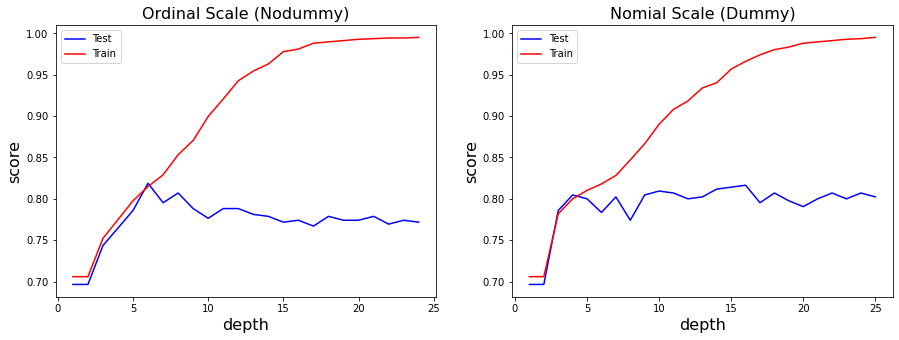

In [37]:
data = [score_table_nodummy, score_table_dummy]
titles = ["Ordinal Scale (Nodummy)", "Nomial Scale (Dummy)"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for i in range(len(data)):
    line1, = ax[i].plot(data[i]["Depth"], data[i]["Score test"], color="b", label='Test')
    line2, = ax[i].plot(data[i]["Depth"], data[i]["Score train"], color="r", label='Train')
   
    ax[i].set_xlabel("depth", fontsize=16)
    ax[i].set_ylabel("score", fontsize=16)
    ax[i].set_title(titles[i], fontsize=16)
    ax[i].legend([line1, line2], ['Test', 'Train'])

plt.show()

Die Varianten unterscheiden sich kaum. Mit der Variante ohne Dummies kann allerdings eine minimal höhere Accuracy erreicht werden. 

(81,88% Accuracy auf Testdaten bei Nodummy Vs. 81,65% Accuracy auf Testdaten bei Dummy)

#### Test auf optimale Variablenkombination

In [38]:
feature_list = ["Quelle", "Transaktionen", "letzte Aenderung", "erste Aenderung", "Online-Bestellung", 
               "Weiblich", "Privatadresse", "Inland"]

feature_combinations = list(powerset(feature_list))
feature_combinations = prepare_feature_combinations(feature_combinations)

train_results = []
test_results = []

y = Y_nodummy_class

for i, fc in enumerate(feature_combinations):
    
    st = str("Compute features combination {}".format(i))
    print(st, end="\r", flush=True)
    
    # input features
    x = X_nodummy_class[fc]
    
    
    # split data
    X_train_tree, X_test_tree, Y_train_tree, Y_test_tree = train_test_split(x,y, random_state=42)
    
    # model
    DecTree = DecisionTreeClassifier(random_state=42)

    # train
    DecTree.fit(X_train_tree, Y_train_tree)
    
    # Dec. Tree results
    train_results.append(DecTree.score(X_train_tree, Y_train_tree))
    test_results.append(DecTree.score(X_test_tree, Y_test_tree))

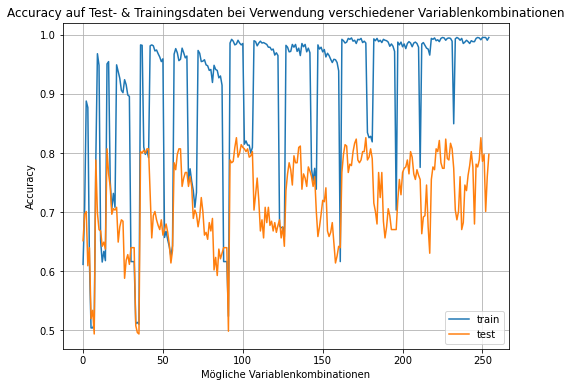

In [39]:
fig = plt.figure(figsize=(8, 6))
plt.plot(train_results, label="train")
plt.plot(test_results, label="test")
plt.legend()
plt.xlabel("Mögliche Variablenkombinationen")
plt.ylabel("Accuracy")
plt.title("Accuracy auf Test- & Trainingsdaten bei Verwendung verschiedener Variablenkombinationen")
plt.grid()

#### Identifikation der besten Variablenkombination

In [40]:
best_combination_id = np.where((np.array(test_results) > 0.825))         # ungefährer Wert aus Darstellung oben abgelesen
for bci in best_combination_id[0]:
    print("fc: {} | res: {}".format(feature_combinations[bci], test_results[bci]))

fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Inland'] | res: 0.8258823529411765
fc: ['Quelle', 'Transaktionen', 'erste Aenderung', 'Privatadresse', 'Inland'] | res: 0.8258823529411765
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Weiblich', 'Privatadresse', 'Inland'] | res: 0.8258823529411765


Das beste Ergebnis wird mit folgenden erklärenden Variablen erzielt: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Weiblich', 'Privatadresse', 'Inland']. Es wird also nur "Online-Bestellung" ausgeschlossen.
Im Folgenden werden nun drei Versionen getestet:
* Decision Tree mit allen Dummy Variablen
* Decision Tree mit den ausgewählten Dummy Variablen (aus dem Test ohne Dummies)
* Decision Tree mit den ausgewählten Variablen (ohne Dummies)

#### Erklärende Variablen festlegen

In [41]:
expl_var_tree_nodummy = ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Weiblich', 'Privatadresse', 
                         'Inland']

expl_var_tree_dummy = ['Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Weiblich', 'Privatadresse', 'Inland', 
                       "Quelle_A", "Quelle_B", "Quelle_C", "Quelle_D", "Quelle_E", "Quelle_H", "Quelle_M", "Quelle_O", 
                       "Quelle_P", "Quelle_R", "Quelle_S", "Quelle_T", "Quelle_U", "Quelle_W", "Quelle_X"]

#### No parameter optimization test/train (alle Variablen Dummy)

In [42]:
DecTree = DecisionTreeClassifier(random_state=42).fit(x_train_dummy_class, y_train_dummy_class)

print("Accuracy Trainingsdaten =", DecTree.score(x_train_dummy_class, y_train_dummy_class))
print("Accuracy Testdaten =", DecTree.score(x_test_dummy_class, y_test_dummy_class))

Accuracy Trainingsdaten = 0.9952941176470588
Accuracy Testdaten = 0.8047058823529412


#### No parameter optimization test/train (ausgewählte Variablen Dummy)

In [43]:
DecTree = DecisionTreeClassifier(random_state=42).fit(x_train_dummy_class[expl_var_tree_dummy], y_train_dummy_class)

print("Accuracy Trainingsdaten =", DecTree.score(x_train_dummy_class[expl_var_tree_dummy], y_train_dummy_class))
print("Accuracy Testdaten =", DecTree.score(x_test_dummy_class[expl_var_tree_dummy], y_test_dummy_class))

Accuracy Trainingsdaten = 0.9913725490196078
Accuracy Testdaten = 0.8023529411764706


#### No parameter optimization test/train (ausgewählte Variablen ohne Dummy)

In [44]:
DecTree = DecisionTreeClassifier(random_state=42).fit(x_train_nodummy_class[expl_var_tree_nodummy], y_train_nodummy_class)


print("Accuracy Trainingsdaten =", DecTree.score(x_train_nodummy_class[expl_var_tree_nodummy], y_train_nodummy_class))
print("Accuracy Testdaten =", DecTree.score(x_test_nodummy_class[expl_var_tree_nodummy], y_test_nodummy_class))

Accuracy Trainingsdaten = 0.9913725490196078
Accuracy Testdaten = 0.8258823529411765


Das beste Ergebnis auf Testdaten wird ohne Dummies und mit den ausgewählten Variablen erzielt. Diese Variante wird daher für die Hyperparameter-Optimierung verwendet. Vorher wird getestet, ob es sinnvoll ist, die Daten vorher zu skalieren.
Bei Betrachtung der Accuracies zwischen Test- und Trainingsdaten fällt außerdem auf, dass ein starkes Overfitting vorliegt. Das liegt daran, dass der Decision Tree sich ohne Optimierungen (z.B. maximale Tiefe) so lange aufbaut, bis er perfekt auf die Trainingsdaten angepasst ist. Dafür verschlechtert sich allerdings die Performance auf den Testdaten.

#### Definition der Datensätze für das weitere Vorgehen

In [45]:
x_DecTree = X_nodummy_class[expl_var_tree_nodummy]
y_DecTree = Y_nodummy_class
x_train_DecTree = x_train_nodummy_class[expl_var_tree_nodummy]
y_train_DecTree = y_train_nodummy_class
x_test_DecTree = x_test_nodummy_class[expl_var_tree_nodummy]
y_test_DecTree = y_test_nodummy_class

#### Cross validation without parameter optimization (not scaled)

In [46]:
cv = StratifiedKFold(n_splits = 10)

clf = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, x_DecTree, y_DecTree, cv = cv)

print("Cross validation scores for decision tree: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())

Cross validation scores for decision tree: 
Scores:	:  [0.75294118 0.75294118 0.82941176 0.79411765 0.81764706 0.8
 0.8        0.82941176 0.72941176 0.79411765]
Mean:			 0.790
Std. deviation: 	 0.032


#### Cross validation without parameter optimization (scaled)

In [47]:
cv = StratifiedKFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('DecTree', DecisionTreeClassifier(random_state=42))])

scores = cross_val_score(pipe, x_DecTree, y_DecTree, cv = cv)

print("\nCross validation scores for decision tree with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for decision tree with pipeline: 
Scores:	:  [0.75294118 0.75294118 0.82941176 0.79411765 0.81764706 0.8
 0.8        0.82941176 0.72941176 0.79411765]
Mean:			 0.790
Std. deviation: 	 0.032


Die Ergebnisse sind gleich, daher wird für die Hyperparameter-Optimierung der Einfachheit halber die Variante ohne Skalierung verwendet.

#### Hyperparameter Optimierung (Test-Training)

In [48]:
cv = StratifiedKFold(n_splits = 15)
DecTree = DecisionTreeClassifier(random_state=42).fit(x_train_DecTree, y_train_DecTree)
print("Accuracy without hyperparameter optimization:\t %.3f" % DecTree.score(x_test_DecTree, y_test_DecTree))

range_max_depth = np.arange(start=1, stop=30, step=2, dtype=int)
range_min_samples_leaf = np.arange(start=1, stop=50, step=1, dtype=int)

param_grid = [ 
    {'max_depth': np.arange(start=1, stop=15, step=1, dtype=int),
     'min_samples_leaf': np.arange(start=1, stop=10, step=1, dtype=int),
     'criterion':["gini", "entropy"],
     'splitter': ["best", "random"],
     }
]

DecTree = DecisionTreeClassifier(random_state=42)
search = GridSearchCV(estimator=DecTree, param_grid=param_grid, cv=cv, n_jobs=-1, 
                      scoring = ['accuracy', 'precision', 'f1', 'recall'], refit = 'accuracy')
search.fit(x_train_DecTree, y_train_DecTree)

print("\nResults of hyperparameter search on training-set")
print("Best accuracy:\t\t %.3f" % search.best_score_)
print("Best hyperparameters:\t %s" % search.best_params_)
print("Best estimator:\t\t %s" % search.best_estimator_)

best_tree = search.best_estimator_
best_tree.fit(x_train_DecTree, y_train_DecTree)
print("\nAccuracy on test-set with hyperparameter optimization:\t %.3f" % best_tree.score(x_test_DecTree, y_test_DecTree))

Accuracy without hyperparameter optimization:	 0.826

Results of hyperparameter search on training-set
Best accuracy:		 0.809
Best hyperparameters:	 {'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 9, 'splitter': 'best'}
Best estimator:		 DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=9,
                       random_state=42)

Accuracy on test-set with hyperparameter optimization:	 0.833


#### Betrachtung alternativer Gütemaße

In [49]:
df_results_gridsearch = pd.DataFrame(search.cv_results_)
pd.options.display.max_colwidth = 120
print('\033[1m'"Best Accuracy:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_accuracy']<=5][['params', 'mean_test_accuracy','rank_test_accuracy']].sort_values(by = 'rank_test_accuracy', axis = 0))
print('\033[1m'"Best Precision:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_precision']<=5][['params', 'mean_test_precision','rank_test_precision']].sort_values(by = 'rank_test_precision', axis = 0))
print('\033[1m'"Best Recall:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_recall']<=5][['params', 'mean_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_recall', axis = 0))
print('\033[1m'"Best F1:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_f1']<=5][['params', 'mean_test_f1', 'rank_test_f1']].sort_values(by = 'rank_test_f1', axis = 0))

Best Accuracy:


,params,mean_test_accuracy,rank_test_accuracy
484,"{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 9, 'splitter': 'best'}",0.808627,1
482,"{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 8, 'splitter': 'best'}",0.806275,2
196,"{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 9, 'splitter': 'best'}",0.804706,3
214,"{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 9, 'splitter': 'best'}",0.803137,4
247,"{'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 7, 'splitter': 'random'}",0.803137,4


Best Precision:


,params,mean_test_precision,rank_test_precision
51,"{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 8, 'splitter': 'random'}",0.964535,1
53,"{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 9, 'splitter': 'random'}",0.964535,1
303,"{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'splitter': 'random'}",0.964535,1
305,"{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 9, 'splitter': 'random'}",0.964535,1
49,"{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 7, 'splitter': 'random'}",0.937684,5
301,"{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 7, 'splitter': 'random'}",0.937684,5


Best Recall:


,params,mean_test_recall,rank_test_recall
0,"{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'splitter': 'best'}",1.0,1
264,"{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 7, 'splitter': 'best'}",1.0,1
266,"{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 8, 'splitter': 'best'}",1.0,1
268,"{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 9, 'splitter': 'best'}",1.0,1
270,"{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'splitter': 'best'}",1.0,1
271,"{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'splitter': 'random'}",1.0,1
272,"{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'splitter': 'best'}",1.0,1
262,"{'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 6, 'splitter': 'best'}",1.0,1
273,"{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'splitter': 'random'}",1.0,1
275,"{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'splitter': 'random'}",1.0,1


Best F1:


,params,mean_test_f1,rank_test_f1
484,"{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 9, 'splitter': 'best'}",0.815557,1
112,"{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'splitter': 'best'}",0.814595,2
479,"{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 6, 'splitter': 'random'}",0.812511,3
247,"{'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 7, 'splitter': 'random'}",0.812152,4
482,"{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 8, 'splitter': 'best'}",0.811297,5


Hier zeigt sich, welche Parameter die beste Accuracy liefern. Diese werden aufgrund der Aufgabenstellung auch als beste Parameter gewertet.

Tatsächlich könnte es sinnvoll sein, nicht bzw. nicht nur die beste Accuracy als Bewertungsmaßstab zu nutzen (Erklärung siehe oben).

#### Nested Cross Validation mit optimierten Parametern (um finale Accuracy zu bestimmen)

In [50]:
inner_cv = StratifiedKFold(n_splits = 10)
outer_cv = StratifiedKFold(n_splits = 10)

param_grid = [
    {'max_depth': [13],
     'min_samples_leaf': [9],
     'criterion':["entropy"],
     'splitter': ["best"],
     'min_samples_split':[2]}
]

clf = DecisionTreeClassifier(random_state=42)
search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=inner_cv)
scores_dectree = cross_val_score(search,x_DecTree, y_DecTree, cv=outer_cv)

print("Accuracy of decision tree: ")
print("Scores:\t: ", scores_dectree)
print("Mean:\t %.3f" % scores_dectree.mean())
print("Std:\t %.3f" % scores_dectree.std())

Accuracy of decision tree: 
Scores:	:  [0.81176471 0.72352941 0.85294118 0.79411765 0.83529412 0.8
 0.84117647 0.78235294 0.76470588 0.81764706]
Mean:	 0.802
Std:	 0.037


**Finale Modellgüte für den Decision Tree liegt bei 80,2%.**

## 3.3 Random Forest

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> Dummy-Variante

,Score test,Score train,Depth
0,0.741176,0.733333,1
1,0.771765,0.756863,2
2,0.800000,0.789020,3
3,0.816471,0.824314,4
4,0.823529,0.825882,5
5,0.828235,0.840000,6
6,0.840000,0.864314,7
7,0.844706,0.882353,8
8,0.837647,0.891765,9
9,0.835294,0.923922,10


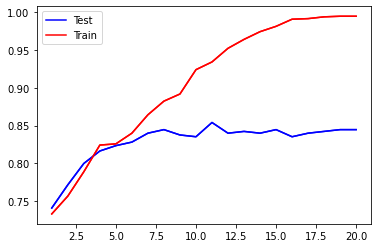

In [51]:
score_test = []
score_train = []
complexity = []


for i in range(1, 21):
    RanFor = RandomForestClassifier(max_depth=i, random_state=42)
    RanFor = RanFor.fit(x_train_dummy_class, y_train_dummy_class)
    score_train.append(RanFor.score(x_train_dummy_class, y_train_dummy_class))
    score_test.append(RanFor.score(x_test_dummy_class, y_test_dummy_class))
    complexity.append(i)
    
score_table_dummy = pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity})

display(score_table_dummy)

plt.plot(score_table_dummy["Depth"], score_table_dummy["Score test"], color="b")
plt.plot(score_table_dummy["Depth"], score_table_dummy["Score train"], color="r")

line1, = plt.plot(score_table_dummy["Depth"], score_table_dummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_dummy["Depth"], score_table_dummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Optimale Baumtiefe ohne weitere Optimierungen für die Dummy-Variante bei 11

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> No Dummy-Variante

,Score test,Score train,Depth
0,0.705882,0.709804,1
1,0.752941,0.756078,2
2,0.783529,0.786667,3
3,0.795294,0.810980,4
4,0.828235,0.831373,5
5,0.830588,0.854118,6
6,0.837647,0.870588,7
7,0.830588,0.904314,8
8,0.844706,0.930980,9
9,0.849412,0.945882,10


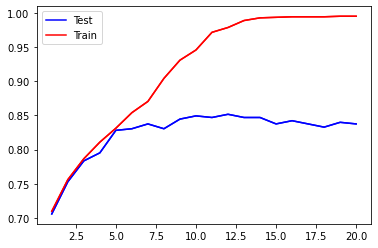

In [52]:
score_test = []
score_train = []
complexity = []


for i in range(1, 21):
    RanFor = RandomForestClassifier(max_depth=i, random_state=42)
    RanFor = RanFor.fit(x_train_nodummy_class, y_train_nodummy_class)
    score_train.append(RanFor.score(x_train_nodummy_class, y_train_nodummy_class))
    score_test.append(RanFor.score(x_test_nodummy_class, y_test_nodummy_class))
    complexity.append(i)
    
score_table_nodummy = pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity})

display(score_table_nodummy)

plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score test"], color="b")
plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score train"], color="r")

line1, = plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Optimale Baumtiefe ohne weitere Optimierungen für die No-Dummy-Variante bei 12

#### Vergleich der Performance bei verschiedenen Baumtiefen: Dummy vs. no Dummy

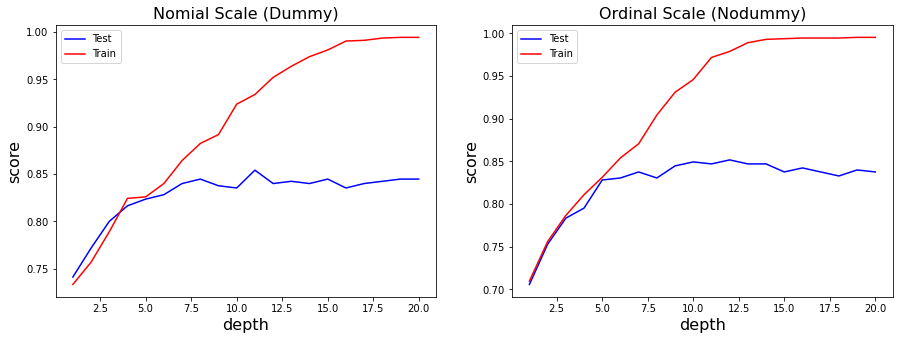

In [53]:
data = [score_table_dummy, score_table_nodummy]
titles = ["Nomial Scale (Dummy)", "Ordinal Scale (Nodummy)"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for i in range(len(data)):
    line1, = ax[i].plot(data[i]["Depth"], data[i]["Score test"], color="b", label='Test')
    line2, = ax[i].plot(data[i]["Depth"], data[i]["Score train"], color="r", label='Train')
   
    ax[i].set_xlabel("depth", fontsize=16)
    ax[i].set_ylabel("score", fontsize=16)
    ax[i].set_title(titles[i], fontsize=16)
    ax[i].legend([line1, line2], ['Test', 'Train'])

plt.show()

Zwischen den Varianten mit bzw. ohne Dummies gibt es keinen zu großen Unterschied.

#### Test auf optimale Variablenkombination

In [54]:
feature_list = ["Quelle", "Transaktionen", "letzte Aenderung", "erste Aenderung", "Online-Bestellung", 
               "Weiblich", "Privatadresse", "Inland"]

feature_combinations = list(powerset(feature_list))
feature_combinations = prepare_feature_combinations(feature_combinations)

train_results = []
test_results = []

y = Y_nodummy_class

for i, fc in enumerate(feature_combinations):
    
    st = str("Compute features combination {}".format(i))
    print(st, end="\r", flush=True)
    
    # input features
    x = X_nodummy_class[fc]
    
    
    # split data
    X_train_tree, X_test_tree, Y_train_tree, Y_test_tree = train_test_split(x,y, random_state=42)
    
    # model
    RanFor = RandomForestClassifier(random_state=42)

    # train
    RanFor.fit(X_train_tree, Y_train_tree)
    
    # Ran For results
    train_results.append(RanFor.score(X_train_tree, Y_train_tree))
    test_results.append(RanFor.score(X_test_tree, Y_test_tree))

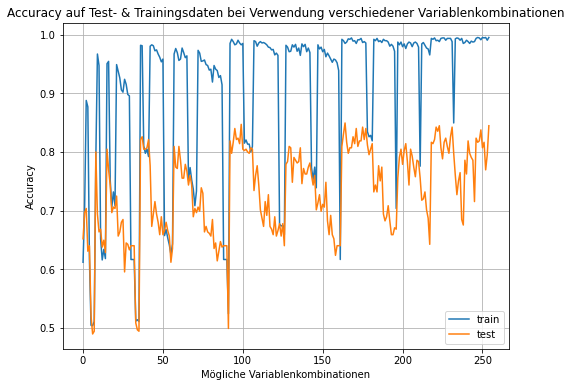

In [55]:
fig = plt.figure(figsize=(8, 6))
plt.plot(train_results, label="train")
plt.plot(test_results, label="test")
plt.legend()
plt.xlabel("Mögliche Variablenkombinationen")
plt.ylabel("Accuracy")
plt.title("Accuracy auf Test- & Trainingsdaten bei Verwendung verschiedener Variablenkombinationen")
plt.grid()

In [56]:
best_combination_id = np.where((np.array(test_results) > 0.847))        # ungefährer Wert aus Darstellung oben abgelesen
for bci in best_combination_id[0]:
    print("fc: {} | res: {}".format(feature_combinations[bci], test_results[bci]))

fc: ['Quelle', 'Transaktionen', 'erste Aenderung', 'Privatadresse'] | res: 0.8470588235294118
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Privatadresse'] | res: 0.8494117647058823


Das beste Ergebnis wird mit folgenden erklärenden Variablen erzielt: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Privatadresse']. 
Im folgenden werden nun drei Versionen getestet:
* Decision Tree mit allen Dummy Variablen
* Decision Tree mit den ausgewählten Dummy Variablen
* Decision Tree mit den ausgewählten Variablen (ohne Dummies)

#### Erklärende Variablen festlegen

In [57]:
expl_var_ranfor_nodummy = ['Quelle', 'Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Privatadresse']

expl_var_ranfor_dummy = ['Transaktionen', 'letzte Aenderung', 'erste Aenderung', 'Privatadresse', "Quelle_A", "Quelle_B", 
                         "Quelle_C", "Quelle_D", "Quelle_E", "Quelle_H", "Quelle_M", "Quelle_O", "Quelle_P", "Quelle_R", 
                         "Quelle_S", "Quelle_T", "Quelle_U", "Quelle_W", "Quelle_X"]

#### No parameter optimization test/train (alle Variablen Dummy)

In [58]:
RanFor = RandomForestClassifier(random_state=42).fit(x_train_dummy_class, y_train_dummy_class)

print('Score (training): {:.3f}'
     .format(RanFor.score(x_train_dummy_class, y_train_dummy_class)))
print('Score (test): {:.3f}'
     .format(RanFor.score(x_test_dummy_class, y_test_dummy_class)))

Score (training): 0.995
Score (test): 0.835


#### No parameter optimization test/train (ausgewählte Variablen Dummy)

In [59]:
RanFor = RandomForestClassifier(random_state=42).fit(x_train_dummy_class[expl_var_ranfor_dummy], y_train_dummy_class)

print('Score (training): {:.3f}'
     .format(RanFor.score(x_train_dummy_class[expl_var_ranfor_dummy], y_train_dummy_class)))
print('Score (test): {:.3f}'
     .format(RanFor.score(x_test_dummy_class[expl_var_ranfor_dummy], y_test_dummy_class)))

Score (training): 0.986
Score (test): 0.854


#### No parameter optimization test/train (ausgewählte Variablen no Dummy)

In [60]:
RanFor = RandomForestClassifier(random_state=42).fit(x_train_nodummy_class[expl_var_ranfor_nodummy], y_train_nodummy_class)

print('Score (training): {:.3f}'
     .format(RanFor.score(x_train_nodummy_class[expl_var_ranfor_nodummy], y_train_nodummy_class)))
print('Score (test): {:.3f}'
     .format(RanFor.score(x_test_nodummy_class[expl_var_ranfor_nodummy], y_test_nodummy_class)))

Score (training): 0.985
Score (test): 0.849


Die Ergebnisse unterscheiden sich kaum. Bei mehrmaligem Testen ohne Random State war häufig außerdem die Variante ohne Dummies am besten. Diese wird der Einfachheit halber daher für das weitere Vorgehen verwendet.Vorher wird anhand Cross Validation getestet, ob es sinnvoll ist, die Daten zu skalieren.

#### Definition der Datensätze für das weitere Vorgehen

In [61]:
x_RanFor = X_nodummy_class[expl_var_ranfor_nodummy]
y_RanFor = Y_nodummy_class
x_train_RanFor = x_train_nodummy_class[expl_var_ranfor_nodummy]
y_train_RanFor = y_train_nodummy_class
x_test_RanFor = x_test_nodummy_class[expl_var_ranfor_nodummy]
y_test_RanFor = y_test_nodummy_class

#### Cross validation without parameter optimization (not scaled)

In [62]:
cv = StratifiedKFold(n_splits = 10)

clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, x_RanFor, y_RanFor, cv = cv)

print("Cross validation scores for random forest: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())

Cross validation scores for random forest: 
Scores:	:  [0.8        0.79411765 0.81176471 0.8        0.88823529 0.78235294
 0.85882353 0.82352941 0.79411765 0.80588235]
Mean:			 0.816
Std. deviation: 	 0.031


#### Cross validation without parameter optimization (scaled)

In [63]:
cv = StratifiedKFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('RanFor', RandomForestClassifier(random_state=42))])

scores = cross_val_score(pipe, x_RanFor, y_RanFor, cv = cv)

print("\nCross validation scores for random forest with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for random forest with pipeline: 
Scores:	:  [0.8        0.79411765 0.81176471 0.8        0.88235294 0.78235294
 0.85882353 0.82352941 0.79411765 0.80588235]
Mean:			 0.815
Std. deviation: 	 0.030


Die Ergebnisse sind annähernd gleich, daher wird für die Hyperparameter-Optimierung der Einfachheit halber die Variante ohne Skalierung verwendet.

#### Hyperparameter Optimierung (Test-Training)

In [64]:
cv = StratifiedKFold(n_splits = 10)
RanFor = RandomForestClassifier().fit(x_train_RanFor, y_train_RanFor)
print("Accuracy without hyperparameter optimization:\t %.3f" % RanFor.score(x_test_RanFor, y_test_RanFor))

range_max_depth = np.arange(start=1, stop=30, step=2, dtype=int)
range_min_samples_leaf = np.arange(start=1, stop=50, step=1, dtype=int)

param_grid = [ 
    {'n_jobs':[-1],
     'max_depth':np.arange(start = 5, stop = 15, step = 1),
     'n_estimators':np.arange(start = 50, stop = 150, step = 10),
     'criterion':['gini' , 'entropy']}
]

RanFor = RandomForestClassifier(random_state=42)
search = GridSearchCV(estimator=RanFor, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=4, 
                      scoring = ['accuracy', 'precision', 'f1', 'recall'], refit = 'accuracy')
search.fit(x_train_RanFor, y_train_RanFor)

print("\nResults of hyperparameter search on training-set")
print("Best accuracy:\t\t %.3f" % search.best_score_)
print("Best hyperparameters:\t %s" % search.best_params_)
print("Best estimator:\t\t %s" % search.best_estimator_)

best_RanFor = search.best_estimator_
best_RanFor.fit(x_train_RanFor, y_train_RanFor)
print("\nAccuracy on test-set with hyperparameter optimization:\t %.3f" % best_RanFor.score(x_test_RanFor, y_test_RanFor))

Accuracy without hyperparameter optimization:	 0.859
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.1min finished



Results of hyperparameter search on training-set
Best accuracy:		 0.827
Best hyperparameters:	 {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 120, 'n_jobs': -1}
Best estimator:		 RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=120,
                       n_jobs=-1, random_state=42)

Accuracy on test-set with hyperparameter optimization:	 0.861


#### Betrachtung alternativer Gütemaße

In [65]:
df_results_gridsearch = pd.DataFrame(search.cv_results_)
pd.options.display.max_colwidth = 120
print('\033[1m'"Best Accuracy:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_accuracy']<=5][['params', 'mean_test_accuracy','rank_test_accuracy']].sort_values(by = 'rank_test_accuracy', axis = 0))
print('\033[1m'"Best Precision:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_precision']<=5][['params', 'mean_test_precision','rank_test_precision']].sort_values(by = 'rank_test_precision', axis = 0))
print('\033[1m'"Best Recall:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_recall']<=5][['params', 'mean_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_recall', axis = 0))
print('\033[1m'"Best F1:")
display(df_results_gridsearch[df_results_gridsearch['rank_test_f1']<=5][['params', 'mean_test_f1', 'rank_test_f1']].sort_values(by = 'rank_test_f1', axis = 0))

Best Accuracy:


,params,mean_test_accuracy,rank_test_accuracy
147,"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 120, 'n_jobs': -1}",0.826729,1
148,"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 130, 'n_jobs': -1}",0.826722,2
48,"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 130, 'n_jobs': -1}",0.825941,3
149,"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 140, 'n_jobs': -1}",0.825935,4
46,"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 110, 'n_jobs': -1}",0.825929,5


Best Precision:


,params,mean_test_precision,rank_test_precision
67,"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 120, 'n_jobs': -1}",0.804787,1
60,"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 50, 'n_jobs': -1}",0.803074,2
65,"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 100, 'n_jobs': -1}",0.802931,3
66,"{'criterion': 'gini', 'max_depth': 11, 'n_estimators': 110, 'n_jobs': -1}",0.802435,4
48,"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 130, 'n_jobs': -1}",0.802208,5


Best Recall:


,params,mean_test_recall,rank_test_recall
107,"{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 120, 'n_jobs': -1}",0.918966,1
108,"{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 130, 'n_jobs': -1}",0.917404,2
106,"{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 110, 'n_jobs': -1}",0.915865,3
109,"{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 140, 'n_jobs': -1}",0.915841,4
100,"{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 50, 'n_jobs': -1}",0.912764,5


Best F1:


,params,mean_test_f1,rank_test_f1
138,"{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 130, 'n_jobs': -1}",0.837351,1
147,"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 120, 'n_jobs': -1}",0.837154,2
148,"{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 130, 'n_jobs': -1}",0.836773,3
136,"{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 110, 'n_jobs': -1}",0.836659,4
137,"{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 120, 'n_jobs': -1}",0.836499,5


Hier zeigt sich, welche Parameter die beste Accuracy liefern. Diese werden aufgrund der Aufgabenstellung auch als beste Parameter gewertet.

Tatsächlich könnte es sinnvoll sein, nicht bzw. nicht nur die beste Accuracy als Bewertungsmaßstab zu nutzen (Erklärung siehe oben).

#### Nested Cross Validation mit optimierten Parametern (um finale Accuracy zu bestimmen)

In [66]:
inner_cv = StratifiedKFold(n_splits = 10)
outer_cv = StratifiedKFold(n_splits = 10)

param_grid = [
    {'n_jobs':[-1],
     'max_depth':[9],
     'n_estimators':[120],
     'criterion':['entropy']}
]

clf = RandomForestClassifier(random_state=42)
search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=inner_cv, n_jobs=-1)
scores_ranfor = cross_val_score(search,x_RanFor, y_RanFor, cv=outer_cv)

print("Accuracy of random forest: ")
print("Scores:\t: ", scores_ranfor)
print("Mean:\t %.3f" % scores_ranfor.mean())
print("Std:\t %.3f" % scores_ranfor.std())

Accuracy of random forest: 
Scores:	:  [0.85294118 0.77058824 0.83529412 0.82352941 0.87058824 0.79411765
 0.88823529 0.81764706 0.81764706 0.87058824]
Mean:	 0.834
Std:	 0.035


**Finale Güte für den Random Forest Classifier liegt bei 83,4%.**

#### Zusammenfassung der Klassifikationsmodelle

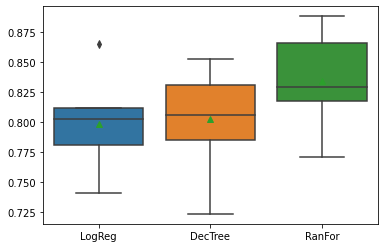

In [67]:
class_summary = df_plot = pd.DataFrame(
        {'LogReg': scores_logreg,
         'DecTree': scores_dectree,
         'RanFor': scores_ranfor}
)

sns.boxplot(data = class_summary, showmeans=True)

plt.show()

Es ist klar erkennbar, dass das beste Modell der Random Forest ist, da die Accuracy hier am höchsten ist.

## 4. Regressionsmodelle

### Split in Test- und Trainingsset

In [68]:
# Definiere Datensatz nur mit Käufern
df_buy_dummy = df_dummy[df_dummy["Kauf"]==1]
df_buy_nodummy = df_nodummy[df_nodummy["Kauf"]==1]

# Definiere X und Y für dummy / no dummy 
X_dummy = df_buy_dummy[expl_var_dummy]
Y_dummy = df_buy_dummy[target_umsatz]
X_nodummy = df_buy_nodummy[expl_var_nodummy]
Y_nodummy = df_buy_nodummy[target_umsatz]

# Split in Test- und Trainingsdaten für Dummy-Satz und No-Dummy-Satz
x_train_dummy, x_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, Y_dummy, random_state = 42)
x_train_nodummy, x_test_nodummy, y_train_nodummy, y_test_nodummy = train_test_split(X_nodummy, Y_nodummy, random_state = 42)

display(df_buy_dummy.head(10))
display(df_buy_nodummy.head(10))

,ID,Inland,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse,Kauf,Umsatz,Intervall letzte Aenderung,Intervall erste Aenderung,Quelle_A,Quelle_B,Quelle_C,Quelle_D,Quelle_E,Quelle_H,Quelle_M,Quelle_O,Quelle_P,Quelle_R,Quelle_S,Quelle_T,Quelle_U,Quelle_W,Quelle_X
3,108,1,1,2907,2907,0,0,0,1,160,"(2500, 3000]","(2500, 3000]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7,1371,1,2,1920,1942,1,0,1,1,130,"(1500, 2000]","(1500, 2000]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,1920,0,3,2296,2564,1,1,0,1,514,"(2000, 2500]","(2500, 3000]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
14,1539,1,1,3024,3024,1,0,0,1,129,"(3000, 3500]","(3000, 3500]",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15,1987,1,4,1710,2982,0,1,1,1,145,"(1500, 2000]","(2500, 3000]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
20,1477,1,1,2856,2856,1,0,0,1,130,"(2500, 3000]","(2500, 3000]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21,393,1,3,1529,1619,0,0,1,1,424,"(1500, 2000]","(1500, 2000]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
24,279,0,3,1086,2710,0,0,1,1,135,"(1000, 1500]","(2500, 3000]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
25,1361,1,3,3620,3650,1,1,0,1,72,"(3500, 4000]","(3500, 4000]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,623,1,1,717,717,1,1,0,1,30,"(500, 1000]","(500, 1000]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


,ID,Inland,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse,Kauf,Umsatz,Intervall letzte Aenderung,Intervall erste Aenderung
3,108,1,13,1,2907,2907,0,0,0,1,160,"(2500, 3000]","(2500, 3000]"
7,1371,1,14,2,1920,1942,1,0,1,1,130,"(1500, 2000]","(1500, 2000]"
8,1920,0,5,3,2296,2564,1,1,0,1,514,"(2000, 2500]","(2500, 3000]"
14,1539,1,4,1,3024,3024,1,0,0,1,129,"(3000, 3500]","(3000, 3500]"
15,1987,1,5,4,1710,2982,0,1,1,1,145,"(1500, 2000]","(2500, 3000]"
20,1477,1,13,1,2856,2856,1,0,0,1,130,"(2500, 3000]","(2500, 3000]"
21,393,1,14,3,1529,1619,0,0,1,1,424,"(1500, 2000]","(1500, 2000]"
24,279,0,13,3,1086,2710,0,0,1,1,135,"(1000, 1500]","(2500, 3000]"
25,1361,1,1,3,3620,3650,1,1,0,1,72,"(3500, 4000]","(3500, 4000]"
26,623,1,13,1,717,717,1,1,0,1,30,"(500, 1000]","(500, 1000]"


### 4.1 Lineare Regression

#### Test auf optimale Variablen-Kombination

In [69]:
feature_list = ["Quelle", "Transaktionen", "letzte Aenderung", "erste Aenderung", "Online-Bestellung", 
               "Weiblich", "Privatadresse", "Inland"]

feature_combinations = list(powerset(feature_list))
feature_combinations = prepare_feature_combinations(feature_combinations)

train_results = []
test_results = []

y = df_buy_nodummy["Umsatz"]

for i, fc in enumerate(feature_combinations):
    
    st = str("Compute features combination {}".format(i))
    print(st, end="\r", flush=True)
    
    # input features
    x = df_buy_nodummy[fc]
    
    # split data
    X_train_lr, X_test_lr, Y_train_lr, Y_test_lr = train_test_split(x,y, random_state=42)
    
    # model
    linreg= LinearRegression()

    # train
    linreg.fit(X_train_lr, Y_train_lr)
    
    # log results
    train_results.append(linreg.score(X_train_lr, Y_train_lr))
    test_results.append(linreg.score(X_test_lr, Y_test_lr))

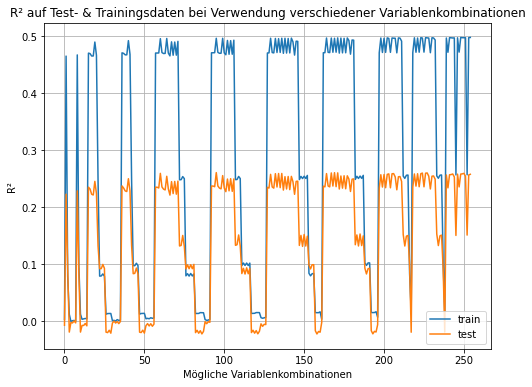

In [70]:
fig = plt.figure(figsize=(8, 6))
plt.plot(train_results, label="train")
plt.plot(test_results, label="test")
plt.legend()
plt.xlabel("Mögliche Variablenkombinationen")
plt.ylabel("R²")
plt.title("R² auf Test- & Trainingsdaten bei Verwendung verschiedener Variablenkombinationen")
plt.grid()

In [71]:
best_combination_id = np.where((np.array(test_results) > 0.26))       # ungefährer Wert aus Darstellung oben abgelesen
for bci in best_combination_id[0]:
    print("fc: {} | res: {}".format(feature_combinations[bci], test_results[bci]))

fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Privatadresse'] | res: 0.2606642872297469
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Online-Bestellung', 'Privatadresse'] | res: 0.2600827136017687
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Weiblich', 'Privatadresse'] | res: 0.2605343482900392
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Privatadresse', 'Inland'] | res: 0.2601971994857092
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Weiblich', 'Privatadresse', 'Inland'] | res: 0.2600573395876612


Das beste Ergebnis wird mit folgenden erklärenden Variablen erzielt: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Privatadresse']. Im folgenden werden nun drei Versionen getestet:
* Lineare Regression mit allen Dummy Variablen
* Lineare Regression mit den idealen Dummy Variablen
* Lineare Regression ohne Dummy Variablen

#### Erklärende Variablen festlegen

In [72]:
expl_var_linreg_nodummy = ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Privatadresse']

expl_var_linreg_dummy = ["Transaktionen", "letzte Aenderung", "Privatadresse", "Quelle_A", "Quelle_B", "Quelle_C", "Quelle_D", 
                         "Quelle_E", "Quelle_H", "Quelle_M", "Quelle_O", "Quelle_P", "Quelle_R", "Quelle_S", "Quelle_T", 
                         "Quelle_U", "Quelle_W", "Quelle_X"]

#### No parameter optimization test/train (alle Variablen Dummy)

In [73]:
linreg = LinearRegression().fit(x_train_dummy, y_train_dummy)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('Score (training): {:.3f}'
     .format(linreg.score(x_train_dummy, y_train_dummy)))
print('Score (test): {:.3f}'
     .format(linreg.score(x_test_dummy, y_test_dummy)))

linear model coeff (w): [-1.79578171e+01 -1.15548149e+01  2.33734591e+00 -8.15701971e+01
  4.52468869e+01 -8.82443586e+00 -6.18928883e+00 -1.22504250e+01
 -2.60029422e+01 -4.73728515e+01 -3.29987481e+01  1.28773394e+01
 -2.62293277e+01  7.64911451e+01 -1.03582673e+01  1.92012401e+00
  3.56569146e+01  1.37466219e+01 -1.57127455e+01  9.69220389e+01
 -5.98343788e-03 -1.32324681e-02]
linear model intercept (b): 67.540
Score (training): 0.518
Score (test): 0.261


#### No parameter optimization test/train (ausgewählte Variablen Dummy)

In [74]:
linreg = LinearRegression().fit(x_train_dummy[expl_var_linreg_dummy], y_train_dummy)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('Score (training): {:.3f}'
     .format(linreg.score(x_train_dummy[expl_var_linreg_dummy], y_train_dummy)))
print('Score (test): {:.3f}'
     .format(linreg.score(x_test_dummy[expl_var_linreg_dummy], y_test_dummy)))

linear model coeff (w): [ 9.32192304e+01 -1.45149446e-02 -7.99833306e+01  4.08491129e+01
 -1.20248579e+01 -8.91657289e+00 -1.51008565e+01 -2.07443893e+01
 -3.62906833e+01 -2.87521475e+01 -3.66096866e+00 -2.89599617e+01
  8.02203164e+01 -1.08580887e+01  1.24259398e+00  3.64302843e+01
  2.51263535e+01 -1.85601345e+01]
linear model intercept (b): 37.279
Score (training): 0.516
Score (test): 0.265


#### No parameter optimization test/train (ausgewählte Variablen ohne Dummy)

In [75]:
linreg = LinearRegression().fit(x_train_nodummy[expl_var_linreg_nodummy], y_train_nodummy)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('Score (training): {:.3f}'
     .format(linreg.score(x_train_nodummy[expl_var_linreg_nodummy], y_train_nodummy)))
print('Score (test): {:.3f}'
     .format(linreg.score(x_test_nodummy[expl_var_linreg_nodummy], y_test_nodummy)))

linear model coeff (w): [ 1.20010864e+00  9.38114291e+01 -1.41335475e-02 -8.34919342e+01]
linear model intercept (b): 43.922
Score (training): 0.496
Score (test): 0.261


Das beste Ergebnis wird mit den ausgewählten Dummy Variablen erreicht. Daher wird diese Version für die Hyperparameter-Optmimierung verwendet. Im Folgenden wird zuerst anhand einer Cross Validation getestet, ob es sinnvoll ist, die Daten für die Hyperparameteroptimierung zu skalieren.

#### Definition der Datensätze für das weitere Vorgehen bei der linearen Regression

In [76]:
x_lr = df_buy_dummy[expl_var_linreg_dummy]
y_lr = df_buy_dummy[target_umsatz]
x_train_lr = x_train_dummy[expl_var_linreg_dummy]
y_train_lr = y_train_dummy
x_test_lr = x_test_dummy[expl_var_linreg_dummy]
y_test_lr = y_test_dummy

#### Cross validation without parameter optimization (not scaled)

In [77]:
cv = KFold(n_splits = 10)

clf = LinearRegression()
scores_linreg = cross_val_score(clf, x_lr, y_lr, cv = cv)

print("Cross validation scores for linear regression: ")
print("Scores:\t: ", scores_linreg)
print("Mean:\t\t\t %.3f" % scores_linreg.mean())
print("Std. deviation: \t %.3f" % scores_linreg.std())

Cross validation scores for linear regression: 
Scores:	:  [0.68361019 0.00423322 0.32136743 0.25309669 0.17381798 0.49711998
 0.63282495 0.60889369 0.64574867 0.29372569]
Mean:			 0.411
Std. deviation: 	 0.222


#### Cross validation without parameter optimization (scaled)

In [78]:
cv = KFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('Lin_Reg', LinearRegression())])

scores = cross_val_score(pipe, x_lr, y_lr, cv = cv)

print("\nCross validation scores for linear regression with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for linear regression with pipeline: 
Scores:	:  [0.68361019 0.00423322 0.32136743 0.25309669 0.17381798 0.49711998
 0.63282495 0.60889369 0.64574867 0.29372569]
Mean:			 0.411
Std. deviation: 	 0.222


Die Ergebnisse unterscheiden sich kaum. Für die Hyperparameter-Optimierung wird daher die nicht skalierte Variante verwendet.

#### Hyperparameter Optimierung (Test-Training)

In [79]:
cv = KFold(n_splits = 10)
clf = LinearRegression().fit(x_train_lr, y_train_lr)
print("Score without hyperparameter optimization:\t %.3f" % clf.score(x_test_lr, y_test_lr))

param_grid = [
    {'normalize': [True, False],
    'copy_X': [True, False]}
]

LinReg = LinearRegression()
search = GridSearchCV(estimator=LinReg, param_grid=param_grid, cv=cv)
search.fit(x_train_lr, y_train_lr)

print("\nResults of hyperparameter search on training-set")
print("Best score:\t\t %.3f" % search.best_score_)
print("Best hyperparameters:\t %s" % search.best_params_)
print("Best estimator:\t\t %s" % search.best_estimator_)

best_linreg = search.best_estimator_
best_linreg.fit(x_train_lr, y_train_lr)
print("\nScore on test-set with hyperparameter optimization:\t %.3f" % best_linreg.score(x_test_lr, y_test_lr))

Score without hyperparameter optimization:	 0.265

Results of hyperparameter search on training-set
Best score:		 0.447
Best hyperparameters:	 {'copy_X': True, 'normalize': False}
Best estimator:		 LinearRegression()

Score on test-set with hyperparameter optimization:	 0.265


Es zeigt sich, dass die Default Parameter schon ideal sind.

#### Nested Cross Validation mit optimierten Parametern (um finales R-Quadrat zu bestimmen)

In [80]:
inner_cv = KFold(n_splits = 10)
outer_cv = KFold(n_splits = 10)

param_grid = [
  {'normalize': [False],
    'copy_X': [True]}
]

LinReg = LinearRegression()
search = GridSearchCV(estimator=LinReg, param_grid=param_grid, cv=inner_cv)
scores_linreg =  cross_val_score(search, x_lr, y_lr, cv=outer_cv)

print("Score of linear regression: ")
print("Mean:\t %.3f" % scores_linreg.mean())
print("Std:\t %.3f" % scores_linreg.std())

Score of linear regression: 
Mean:	 0.411
Std:	 0.222


**Finale Güte (R-Quadrat) der linearen Regression liegt bei 41,1%.**

### 4.2 Lasso Regression

#### Test auf optimale Variablen-Kombination

In [81]:
train_results = []
test_results = []

y = df_buy_nodummy["Umsatz"]

for i, fc in enumerate(feature_combinations):
    
    st = str("Compute features combination {}".format(i))
    print(st, end="\r", flush=True)
    
    # input features
    x = df_buy_nodummy[fc]
    
    
    # split data
    X_train_lasso, X_test_lasso, Y_train_lasso, Y_test_lasso = train_test_split(x,y, test_size=0.25, random_state=42)
    
    # model
    lasso= Lasso(random_state=42)

    # train
    lasso.fit(X_train_lasso, Y_train_lasso)
    
    # log results
    train_results.append(lasso.score(X_train_lasso, Y_train_lasso))
    test_results.append(lasso.score(X_test_lasso, Y_test_lasso))

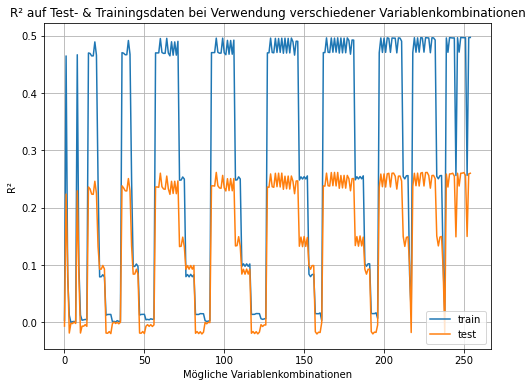

In [82]:
fig = plt.figure(figsize=(8, 6))
plt.plot(train_results, label="train")
plt.plot(test_results, label="test")
plt.legend()
plt.xlabel("Mögliche Variablenkombinationen")
plt.ylabel("R²")
plt.title("R² auf Test- & Trainingsdaten bei Verwendung verschiedener Variablenkombinationen")
plt.grid()

In [83]:
best_combination_id = np.where((np.array(test_results) > 0.2615))       # ungefährer Wert aus Darstellung oben abgelesen
for bci in best_combination_id[0]:
    print("fc: {} | res: {}".format(feature_combinations[bci], test_results[bci]))

fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Privatadresse'] | res: 0.26154487665605786
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Weiblich', 'Privatadresse'] | res: 0.2615448902643155


Das beste Ergebnis wird mit folgenden erklärenden Variablen erzielt: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Weiblich', 'Privatadresse']. Im folgenden werden nun drei Versionen getestet:
* Lasso Regression mit allen Dummy Variablen
* Lasso Regression mit den ausgewählten Dummy Variablen
* Lasso Regression mit den ausgewählten Variablen (ohne Dummies)

#### Erklärende Variablen festlegen

In [84]:
expl_var_lasso_nodummy = ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Weiblich', 'Privatadresse']

expl_var_lasso_dummy = ["Transaktionen", "letzte Aenderung", "Privatadresse", "Weiblich", "Quelle_A", "Quelle_B", "Quelle_C", "Quelle_D", 
                         "Quelle_E", "Quelle_H", "Quelle_M", "Quelle_O", "Quelle_P", "Quelle_R", "Quelle_S", "Quelle_T", 
                         "Quelle_U", "Quelle_W", "Quelle_X"]

#### No parameter optimization test/train (alle Variablen Dummy)

In [85]:
lasso = Lasso(random_state=42).fit(x_train_dummy, y_train_dummy)

print('linear model coeff (w): {}'
     .format(lasso.coef_))
print('linear model intercept (b): {:.3f}'
     .format(lasso.intercept_))
print('Score (training): {:.3f}'
     .format(lasso.score(x_train_dummy, y_train_dummy)))
print('Score (test): {:.3f}'
     .format(lasso.score(x_test_dummy, y_test_dummy)))

linear model coeff (w): [-1.10016448e+01 -6.74819918e+00  0.00000000e+00 -7.77041747e+01
  4.11131597e+01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.58309137e+01 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  6.50898629e+01 -0.00000000e+00  0.00000000e+00
  3.06143120e+01  9.47708683e+00 -0.00000000e+00  9.50035205e+01
 -8.49891617e-03 -1.11837290e-02]
linear model intercept (b): 61.628
Score (training): 0.515
Score (test): 0.264


#### No parameter optimization test/train (ausgewählte Variablen Dummy)

In [86]:
lasso = Lasso(random_state=42).fit(x_train_dummy[expl_var_lasso_dummy], y_train_dummy)

print('linear model coeff (w): {}'
     .format(lasso.coef_))
print('linear model intercept (b): {:.3f}'
     .format(lasso.intercept_))
print('Score (training): {:.3f}'
     .format(lasso.score(x_train_dummy[expl_var_lasso_dummy], y_train_dummy)))
print('Score (test): {:.3f}'
     .format(lasso.score(x_test_dummy[expl_var_lasso_dummy], y_test_dummy)))

linear model coeff (w): [ 9.18019015e+01 -1.59784896e-02 -7.59991474e+01  0.00000000e+00
  3.90768134e+01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.10333225e+01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  6.93726833e+01 -0.00000000e+00  0.00000000e+00
  3.25659636e+01  1.93759331e+01 -0.00000000e+00]
linear model intercept (b): 39.765
Score (training): 0.513
Score (test): 0.266


#### No parameter optimization test/train (ausgewählte Variablen ohne Dummy)

In [87]:
lasso = Lasso(random_state=42).fit(x_train_nodummy[expl_var_lasso_nodummy], y_train_nodummy)

print('linear model coeff (w): {}'
     .format(lasso.coef_))
print('linear model intercept (b): {:.3f}'
     .format(lasso.intercept_))
print('Score (training): {:.3f}'
     .format(lasso.score(x_train_nodummy[expl_var_lasso_nodummy], y_train_nodummy)))
print('Score (test): {:.3f}'
     .format(lasso.score(x_test_nodummy[expl_var_lasso_nodummy], y_test_nodummy)))

linear model coeff (w): [ 1.10997131e+00  9.30531055e+01 -1.43904241e-02 -0.00000000e+00
 -7.74315732e+01]
linear model intercept (b): 45.315
Score (training): 0.496
Score (test): 0.262


Das beste Ergebnis wird mit ausgewählten Dummy-Variablen erzielt. Daher wird diese Version für weitere Berechnungen verwendet. Vorher wird anhand Cross Validation getestet, ob es sinnvoll ist, die Daten zu skalieren.

#### Definition der Datensätze für das weitere Vorgehen bei der Lasso-Regression

In [88]:
x_lasso = df_buy_dummy[expl_var_lasso_dummy]
y_lasso = df_buy_dummy[target_umsatz]
x_train_lasso = x_train_dummy[expl_var_lasso_dummy]
y_train_lasso = y_train_dummy
x_test_lasso = x_test_dummy[expl_var_lasso_dummy]
y_test_lasso = y_test_dummy

#### Cross validation without parameter optimization (not scaled)

In [89]:
cv = KFold(n_splits = 10)

clf = Lasso()
scores_lasso = cross_val_score(clf, x_lasso, y_lasso, cv = cv)

print("Cross validation scores for lasso regression: ")
print("Scores:\t: ", scores_lasso)
print("Mean:\t\t\t %.3f" % scores_lasso.mean())
print("Std. deviation: \t %.3f" % scores_lasso.std())

Cross validation scores for lasso regression: 
Scores:	:  [0.68995569 0.05190269 0.33206755 0.25264123 0.16588177 0.493852
 0.63931463 0.59753212 0.64923414 0.30544592]
Mean:			 0.418
Std. deviation: 	 0.214


#### Cross validation without parameter optimization (scaled)

In [90]:
cv = KFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('Lasso', Lasso())])

scores = cross_val_score(pipe, x_lasso, y_lasso, cv = cv)

print("\nCross validation scores for lasso regression with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for lasso regression with pipeline: 
Scores:	:  [0.66831367 0.06235856 0.34166313 0.26065924 0.16456581 0.49084232
 0.65177394 0.58080905 0.63221323 0.32055193]
Mean:			 0.417
Std. deviation: 	 0.206


Das Ergebnis der nicht-skalierten Variante ist leicht besser (aber kaum erheblich), sie wird daher für die Hyperparameteroptimierung verwendet.

#### Hyperparameter Optimierung (Test-Training)

In [91]:
cv = KFold(n_splits = 10)
clf = Lasso().fit(x_train_lasso, y_train_lasso)
print("Score without hyperparameter optimization:\t %.3f" % clf.score(x_test_lasso, y_test_lasso))

param_grid = [
    {'alpha': np.arange(start=1.0, stop=10.0, step=0.1, dtype=int),
    'normalize': [True, False],
    'selection': ['cyclic', 'random']}
]

lasso = Lasso()
search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=cv)
search.fit(x_train_lasso, y_train_lasso)

print("\nResults of hyperparameter search on training-set")
print("Best score:\t\t %.3f" % search.best_score_)
print("Best hyperparameters:\t %s" % search.best_params_)
print("Best estimator:\t\t %s" % search.best_estimator_)

best_lasso = search.best_estimator_
best_lasso.fit(x_train_lasso, y_train_lasso)
print("\nScore on test-set with hyperparameter optimization:\t %.3f" % best_lasso.score(x_test_lasso, y_test_lasso))

Score without hyperparameter optimization:	 0.266

Results of hyperparameter search on training-set
Best score:		 0.455
Best hyperparameters:	 {'alpha': 1, 'normalize': False, 'selection': 'random'}
Best estimator:		 Lasso(alpha=1, selection='random')

Score on test-set with hyperparameter optimization:	 0.266


#### Nested Cross Validation mit optimierten Parametern (um finales R-Quadrat zu bestimmen)

In [92]:
inner_cv = KFold(n_splits = 10)
outer_cv = KFold(n_splits = 10)

param_grid = [
  {'alpha': [1],
    'normalize': [False],
    'selection': ['random']}
]

clf = Lasso()
search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=inner_cv)
scores_lasso =  cross_val_score(search, x_lr, y_lr, cv=outer_cv)

print("Score of lasso regression: ")
print("Mean:\t %.3f" % scores_lasso.mean())
print("Std:\t %.3f" % scores_lasso.std())

Score of lasso regression: 
Mean:	 0.418
Std:	 0.214


**Finale Güte (R-Quadrat) der Lasso Regression liegt bei 41,8%.**

### 4.3 Decision Tree Regression

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> No Dummy-Variante

,Score test,Score train,Depth,Nodes
0,-0.006161,0.386646,1,3
1,0.192345,0.532294,2,7
2,0.211103,0.566569,3,15
3,0.199787,0.616851,4,29
4,0.248392,0.671264,5,51
5,0.128749,0.729487,6,77
6,0.169955,0.805002,7,117
7,0.124436,0.849810,8,171
8,-0.002101,0.894561,9,237
9,-0.031032,0.914230,10,311


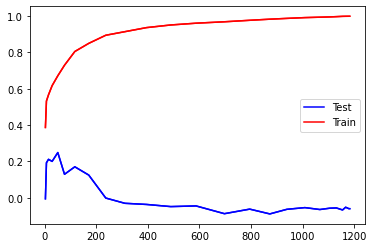

In [93]:
score_test = []
score_train = []
complexity = []
nodes = []

DecTree = DecisionTreeRegressor(random_state=42)
DecTree = DecTree.fit(x_train_nodummy, y_train_nodummy)

for i in range(1, DecTree.tree_.max_depth):
    DecTree = DecisionTreeRegressor(max_depth=i, random_state=42)
    DecTree = DecTree.fit(x_train_nodummy, y_train_nodummy)
    score_train.append(DecTree.score(x_train_nodummy, y_train_nodummy))
    score_test.append(DecTree.score(x_test_nodummy, y_test_nodummy))
    complexity.append(i)
    nodes.append(DecTree.tree_.node_count)
    
score_table_nodummy = pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity, "Nodes":nodes})

display(score_table_nodummy.head(10))

plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score test"], color="b")
plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score train"], color="r")

line1, = plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_nodummy["Nodes"], score_table_nodummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Das beste Ergebnis für die No Dummy-Variante wird mit einer Baumtiefe von 5 erzielt.

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> Dummy-Variante

,Score test,Score train,Depth,Nodes
0,-0.006161,0.386646,1,3
1,0.192345,0.532294,2,7
2,0.215912,0.569297,3,15
3,0.214010,0.619296,4,27
4,0.195962,0.672963,5,47
5,0.164236,0.734470,6,75
6,0.140140,0.821027,7,111
7,0.107637,0.874355,8,161
8,0.068534,0.892973,9,215
9,0.121697,0.910060,10,283


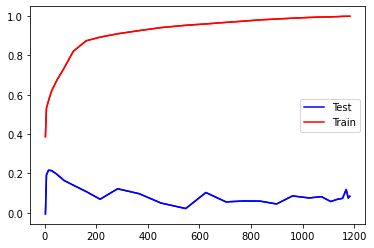

In [94]:
score_test = []
score_train = []
complexity = []
nodes = []

DecTree = DecisionTreeRegressor(random_state=42)
DecTree = DecTree.fit(x_train_dummy, y_train_dummy)

for i in range(1, DecTree.tree_.max_depth):
    DecTree = DecisionTreeRegressor(max_depth=i, random_state=42)
    DecTree = DecTree.fit(x_train_dummy, y_train_dummy)
    score_train.append(DecTree.score(x_train_dummy, y_train_dummy))
    score_test.append(DecTree.score(x_test_dummy, y_test_dummy))
    complexity.append(i)
    nodes.append(DecTree.tree_.node_count)
    
score_table_dummy = pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity, "Nodes":nodes})

display(score_table_dummy.head(10))

plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score test"], color="b")
plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score train"], color="r")

line1, = plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_dummy["Nodes"], score_table_dummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Das beste Ergebnis für die Dummy-Variante wird mit einer Baumtiefe von 3 erzielt.

#### Vergleich der Performance bei verschiedenen Baumtiefen: Dummy vs. no Dummy

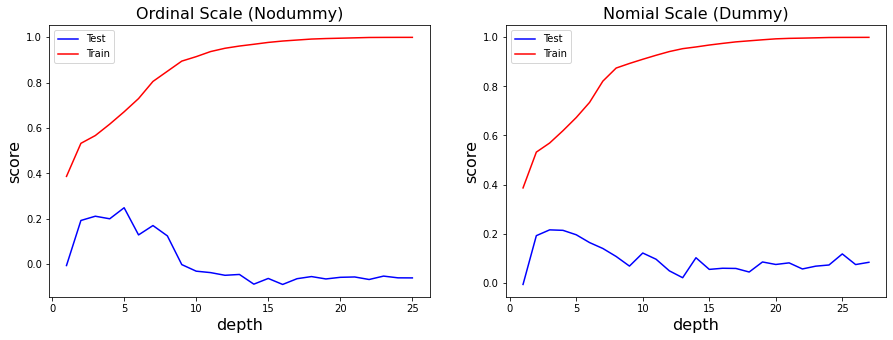

In [95]:
data = [score_table_nodummy, score_table_dummy]
titles = ["Ordinal Scale (Nodummy)", "Nomial Scale (Dummy)"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for i in range(len(data)):
    line1, = ax[i].plot(data[i]["Depth"], data[i]["Score test"], color="b", label='Test')
    line2, = ax[i].plot(data[i]["Depth"], data[i]["Score train"], color="r", label='Train')
   
    ax[i].set_xlabel("depth", fontsize=16)
    ax[i].set_ylabel("score", fontsize=16)
    ax[i].set_title(titles[i], fontsize=16)
    ax[i].legend([line1, line2], ['Test', 'Train'])

plt.show()

Die Ergebnisse sind sehr ähnlich. Bei der Dummy-Variante verschlechtert sich die Performance bei wachsender Baumtiefe allerdings etwas schneller. Mit der Variante ohne Dummies kann insgesamt ein höherer Score erreicht werden.

#### Test auf optimale Variablenkombination

In [96]:
train_results = []
test_results = []

y = df_buy_nodummy["Umsatz"]

for i, fc in enumerate(feature_combinations):
    
    st = str("Compute features combination {}".format(i))
    print(st, end="\r", flush=True)
    
    # input features
    x = df_buy_nodummy[fc]
    
    # split data
    X_train_tr, X_test_tr, Y_train_tr, Y_test_tr = train_test_split(x,y, test_size=0.25, random_state=42)
    
    # model
    treereg= DecisionTreeRegressor(random_state=42)

    # train
    treereg.fit(X_train_tr, Y_train_tr)
    
    # log results
    train_results.append(treereg.score(X_train_tr, Y_train_tr))
    test_results.append(treereg.score(X_test_tr, Y_test_tr))

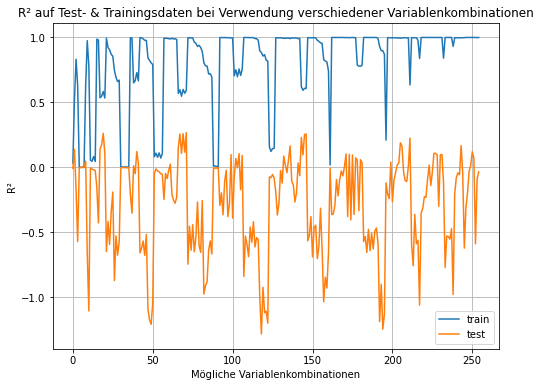

In [97]:
fig = plt.figure(figsize=(8, 6))
plt.plot(train_results, label="train")
plt.plot(test_results, label="test")
plt.legend()
plt.xlabel("Mögliche Variablenkombinationen")
plt.ylabel("R²")
plt.title("R² auf Test- & Trainingsdaten bei Verwendung verschiedener Variablenkombinationen")
plt.grid()

In [98]:
best_combination_id = np.where((np.array(test_results) > 0.26))       # ungefährer Wert aus Darstellung oben abgelesen
for bci in best_combination_id[0]:
    print("fc: {} | res: {}".format(feature_combinations[bci], test_results[bci]))

fc: ['Transaktionen', 'Privatadresse'] | res: 0.2616303720812948
fc: ['Transaktionen', 'Privatadresse', 'Inland'] | res: 0.266949430229


Das beste Ergebnis wird mit folgenden erklärenden Variablen erzielt: ['Transaktionen', 'Privatadresse', 'Inland']. Im Folgenden werden zwei Möglichkeiten getestet:
* Tree Regression mit allen Dummy Variablen
* Tree Regression mit ausgewählten Nicht-Dummy Variablen

#### Erklärende Variablen festlegen

In [99]:
expl_var_treereg = ['Transaktionen', 'Privatadresse', 'Inland']

#### No parameter optimization test/train (alle Variablen Dummy)

In [100]:
treereg = DecisionTreeRegressor(random_state=42).fit(x_train_dummy, y_train_dummy)

print('Score (training): {:.3f}'
     .format(treereg.score(x_train_dummy, y_train_dummy)))
print('Score (test): {:.3f}'
     .format(treereg.score(x_test_dummy, y_test_dummy)))

Score (training): 0.999
Score (test): 0.087


#### No parameter optimization test/train (no Dummy und nur 'Transaktionen', 'Privatadresse', 'Inland')

In [101]:
treereg = DecisionTreeRegressor(random_state=42).fit(x_train_nodummy[expl_var_treereg], 
                                                     y_train_nodummy)

print('Score (training): {:.3f}'
     .format(treereg.score(x_train_nodummy[expl_var_treereg], y_train_nodummy)))
print('Score (test): {:.3f}'
     .format(treereg.score(x_test_nodummy[expl_var_treereg], y_test_nodummy)))

Score (training): 0.592
Score (test): 0.267


Das Ergebnis für die Variante ohne Dummys scheint besser, obwohl die Werte wegen des starken Overfitting bei der Dummy-Variante kaum vergleichbar sind. Da die Variante ohne Dummies aber auch bereits weiter oben beim Vergleich der Baumtiefen einen besseren Eindruck gemacht hat, da mit ihr ein höheres R-Quadrat erreicht werden kann, wird diese für die Hyperparameteroptimierung verwendet. Vorher wird getestet, ob es sinnvoll ist, die Daten zu skalieren.

#### Cross validation without parameter optimization (not scaled)

In [102]:
cv = KFold(n_splits = 10)

clf = DecisionTreeRegressor(random_state=42)
scores_treereg = cross_val_score(clf, df_buy_nodummy[expl_var_treereg], df_buy_nodummy[target_umsatz], cv = cv)

print("Cross validation scores for tree regression: ")
print("Scores:\t: ", scores_treereg)
print("Mean:\t\t\t %.3f" % scores_treereg.mean())
print("Std. deviation: \t %.3f" % scores_treereg.std())

Cross validation scores for tree regression: 
Scores:	:  [0.76284964 0.11135012 0.26768218 0.24945836 0.10849533 0.51216564
 0.58430267 0.67207924 0.76135418 0.41785491]
Mean:			 0.445
Std. deviation: 	 0.239


#### Cross validation without parameter optimization (scaled) 

In [103]:
cv = KFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('Tree_Reg', DecisionTreeRegressor(random_state=42))])

scores = cross_val_score(pipe, df_buy_nodummy[expl_var_treereg], df_buy_nodummy[target_umsatz], cv = cv)

print("\nCross validation scores for tree regression with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for tree regression with pipeline: 
Scores:	:  [0.76284964 0.11135012 0.26768218 0.24945836 0.10849533 0.52359223
 0.58430267 0.67207924 0.76135418 0.41785491]
Mean:			 0.446
Std. deviation: 	 0.239


Die Ergebnisse unterscheiden sich kaum. Der Einfachheit halber wird daher die Variante ohne Skalierung für die Hyperparameter-Optimierung verwendet.

#### Definition der Datensätze für das weitere Vorgehen bei der Tree Regression

In [104]:
x_tr = df_buy_nodummy[expl_var_treereg]
y_tr = df_buy_nodummy[target_umsatz]
x_train_tr = x_train_nodummy[expl_var_treereg]
y_train_tr = y_train_nodummy
x_test_tr = x_test_nodummy[expl_var_treereg]
y_test_tr = y_test_nodummy

#### Hyperparameter Optimierung (Test-Training)

In [105]:
cv = KFold(n_splits = 10)
DecTree = DecisionTreeRegressor(random_state=42).fit(x_train_tr, y_train_tr)
print("Score without hyperparameter optimization:\t %.3f" % DecTree.score(x_test_tr, y_test_tr))

param_grid = [ 
    {'min_samples_split': np.arange(start=2, stop=10, step=1, dtype=int),
     'min_samples_leaf': np.arange(start=1, stop=15, step=1, dtype=int),
     'max_depth': np.arange(start=10, stop=20, step=1, dtype=int)
    }
]

DecTree = DecisionTreeRegressor(random_state=42)

search = GridSearchCV(estimator=DecTree, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=4)
search.fit(x_train_tr, y_train_tr)

print("\nResults of hyperparameter search on training-set")
print("Best score:\t\t %.3f" % search.best_score_)
print("Best hyperparameters:\t %s" % search.best_params_)
print("\nBest estimator:\t\t %s" % search.best_estimator_)

best_treereg = search.best_estimator_
best_treereg.fit(x_train_tr, y_train_tr)
print("\nScore on test-set with hyperparameter optimization:\t %.3f" % best_treereg.score(x_test_tr, y_test_tr))

Score without hyperparameter optimization:	 0.267
Fitting 10 folds for each of 1120 candidates, totalling 11200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1048 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3016 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 5752 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 9288 tasks      | elapsed:   29.4s



Results of hyperparameter search on training-set
Best score:		 0.476
Best hyperparameters:	 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 8}

Best estimator:		 DecisionTreeRegressor(max_depth=10, min_samples_split=8, random_state=42)

Score on test-set with hyperparameter optimization:	 0.268


[Parallel(n_jobs=-1)]: Done 11200 out of 11200 | elapsed:   34.9s finished


#### Nested Cross Validation mit optimierten Parametern (um finales R-Quadrat zu bestimmen)

In [106]:
inner_cv = KFold(n_splits = 10)
outer_cv = KFold(n_splits = 10)

param_grid = [
  {'min_samples_split': [8],
   'min_samples_leaf': [1],
   'max_depth':[10]
    }
]

DecTree = DecisionTreeRegressor(random_state=42)
search = GridSearchCV(estimator=DecTree, param_grid=param_grid, cv=inner_cv)
scores_treereg =  cross_val_score(search, x_tr, y_tr, cv=outer_cv)

print("Score of tree regression: ")
print("Mean:\t %.3f" % scores_treereg.mean())
print("Std:\t %.3f" % scores_treereg.std())

Score of tree regression: 
Mean:	 0.435
Std:	 0.234


**Finale Güte (R-Quadrat) der Tree Regression liegt bei 43,5%.**

### 4.4 Random Forest Regression

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> Dummy-Variante

,Score test,Score train,Depth
0,0.041502,0.423701,1
1,0.201710,0.550816,2
2,0.230596,0.599801,3
3,0.245704,0.677731,4
4,0.237063,0.737635,5
5,0.246186,0.790424,6
6,0.240818,0.830719,7
7,0.238615,0.856590,8
8,0.243622,0.876575,9
9,0.242456,0.891066,10


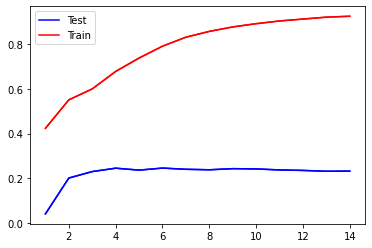

In [107]:
score_test = []
score_train = []
complexity = []

RF = RandomForestRegressor(random_state=42)
RF.fit(x_train_dummy, y_train_dummy)

for i in range(1, 15):
    RF = RandomForestRegressor(max_depth = i, random_state=42)
    RF = RF.fit(x_train_dummy, y_train_dummy)
    score_train.append(RF.score(x_train_dummy, y_train_dummy))
    score_test.append(RF.score(x_test_dummy, y_test_dummy))
    complexity.append(i)

score_table_dummy = pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity})

display(score_table_dummy)
    
plt.plot(score_table_dummy["Depth"], score_table_dummy["Score test"], color="b")
plt.plot(score_table_dummy["Depth"], score_table_dummy["Score train"], color="r")

line1, = plt.plot(score_table_dummy["Depth"], score_table_dummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_dummy["Depth"], score_table_dummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Beste Performance bei einer Baumtiefe von 6

#### Betrachtung der Performance bei verschiedenen Baumtiefen -> No Dummy-Variante

,Score test,Score train,Depth
0,0.041502,0.423701,1
1,0.205138,0.551065,2
2,0.237129,0.594187,3
3,0.253981,0.661872,4
4,0.245664,0.720871,5
5,0.241155,0.782717,6
6,0.236708,0.825340,7
7,0.234464,0.854443,8
8,0.237522,0.878583,9
9,0.246709,0.895153,10


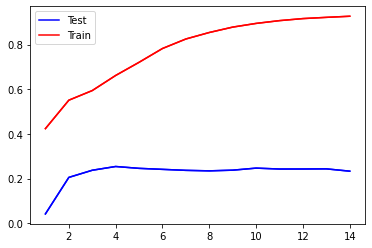

In [108]:
score_test = []
score_train = []
complexity = []

RF = RandomForestRegressor(random_state=42)
RF.fit(x_train_nodummy, y_train_nodummy)

for i in range(1, 15):
    RF = RandomForestRegressor(max_depth = i, random_state=42)
    RF = RF.fit(x_train_nodummy, y_train_nodummy)
    score_train.append(RF.score(x_train_nodummy, y_train_nodummy))
    score_test.append(RF.score(x_test_nodummy, y_test_nodummy))
    complexity.append(i)

score_table_nodummy = pd.DataFrame({"Score test":score_test, "Score train":score_train, "Depth":complexity})

display(score_table_nodummy)
    
plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score test"], color="b")
plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score train"], color="r")

line1, = plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score test"], color="b", label='Test')
line2, = plt.plot(score_table_nodummy["Depth"], score_table_nodummy["Score train"], color="r", label='Train')
plt.legend([line1, line2], ['Test', 'Train'])
plt.show()

Beste Performance bei einer Baumtiefe von 4

#### Vergleich der Performance bei verschiedenen Baumtiefen: Dummy vs. no Dummy

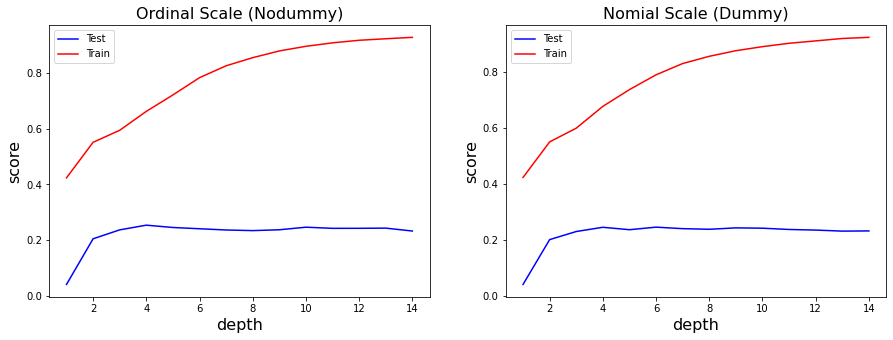

In [109]:
data = [score_table_nodummy, score_table_dummy]
titles = ["Ordinal Scale (Nodummy)", "Nomial Scale (Dummy)"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for i in range(len(data)):
    line1, = ax[i].plot(data[i]["Depth"], data[i]["Score test"], color="b", label='Test')
    line2, = ax[i].plot(data[i]["Depth"], data[i]["Score train"], color="r", label='Train')
   
    ax[i].set_xlabel("depth", fontsize=16)
    ax[i].set_ylabel("score", fontsize=16)
    ax[i].set_title(titles[i], fontsize=16)
    ax[i].legend([line1, line2], ['Test', 'Train'])

plt.show()

Die Varianten unterscheiden sich kaum. Insgesamt kann aber ohne weitere Optimierungen bei der Variante ohne Dummies eine höhere Accuracy erreicht werden.

#### Test auf optimale Variablenkombination

In [110]:
train_results = []
test_results = []

y = df_buy_nodummy["Umsatz"]

for i, fc in enumerate(feature_combinations):
    
    st = str("Compute features combination {}".format(i))
    print(st, end="\r", flush=True)
    
    # input features
    x = df_buy_nodummy[fc]
    
    # split data
    X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(x,y, test_size=0.25, random_state=42)
    
    # model
    rf = RandomForestRegressor(random_state=42)

    # train
    rf.fit(X_train_rf, Y_train_rf)
    
    # log results
    train_results.append(rf.score(X_train_rf, Y_train_rf))
    test_results.append(rf.score(X_test_rf, Y_test_rf))

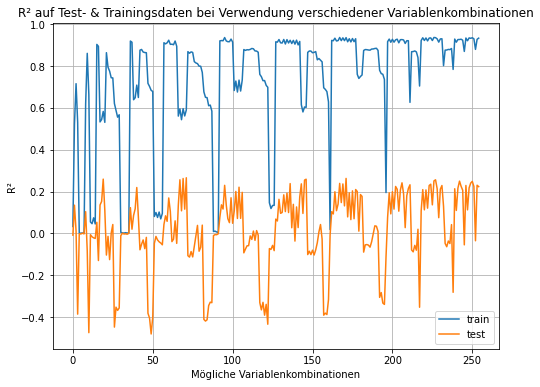

In [111]:
fig = plt.figure(figsize=(8, 6))
plt.plot(train_results, label="train")
plt.plot(test_results, label="test")
plt.legend()
plt.xlabel("Mögliche Variablenkombinationen")
plt.ylabel("R²")
plt.title("R² auf Test- & Trainingsdaten bei Verwendung verschiedener Variablenkombinationen")
plt.grid()

In [112]:
best_combination_id = np.where((np.array(test_results) > 0.26))       # ungefährer Wert aus Darstellung oben abgelesen
for bci in best_combination_id[0]:
    print("fc: {} | res: {}".format(feature_combinations[bci], test_results[bci]))

fc: ['Transaktionen', 'Weiblich', 'Privatadresse'] | res: 0.2623040656668245
fc: ['Transaktionen', 'Privatadresse', 'Inland'] | res: 0.26590816264993744
fc: ['Quelle', 'Transaktionen', 'letzte Aenderung', 'Privatadresse', 'Inland'] | res: 0.26270684328510274


Das beste Ergebnis wird mit folgenden erklärenden Variablen erzielt: ['Transaktionen', 'Privatadresse', 'Inland']. Im Folgenden werden zwei Möglichkeiten getestet:
* Tree Regression mit allen Dummy Variablen
* Tree Regression mit ausgewählten Nicht-Dummy Variablen

#### Erklärende Variablen festlegen

In [113]:
expl_var_rf = ['Transaktionen', 'Privatadresse', 'Inland']

#### No parameter optimization test/train (alle Variablen Dummy)

In [114]:
rf = RandomForestRegressor(random_state=42).fit(x_train_dummy, y_train_dummy)

print('Score (training): {:.3f}'
     .format(rf.score(x_train_dummy, y_train_dummy)))
print('Score (test): {:.3f}'
     .format(rf.score(x_test_dummy, y_test_dummy)))

Score (training): 0.933
Score (test): 0.232


#### No parameter optimization test/train (no Dummy und ausgewählte Variablen)

In [115]:
rf = RandomForestRegressor(random_state=42).fit(x_train_nodummy[expl_var_rf], y_train_nodummy)

print('Score (training): {:.3f}'
     .format(rf.score(x_train_nodummy[expl_var_rf], y_train_nodummy)))
print('Score (test): {:.3f}'
     .format(rf.score(x_test_nodummy[expl_var_rf], y_test_nodummy)))

Score (training): 0.590
Score (test): 0.266


Die Ergebnisse sind an dieser Stelle wenig vergleichbar, da bei der Variante mit allem Dummies ein starkes Overfitting vorliegt. Da bei der Betrachtung der unterschiedlichen Baumtiefen allerdings schon festgestellt wurde, dass ein höheres R-Quadrat mit der Variante ohne Dummies erreicht werden kann, wird diese für die Hyperparameter-Optimierung verwendet. Vorher wird geprüft, ob es sinnvoll ist, die Daten vorher zu skalieren.

#### Cross validation without parameter optimization (not scaled)

In [116]:
cv = KFold(n_splits = 10)

clf = RandomForestRegressor(random_state=42)
scores = cross_val_score(clf, df_buy_nodummy[expl_var_rf], df_buy_nodummy[target_umsatz], cv = cv)

print("Cross validation scores for random forest regression: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())

Cross validation scores for random forest regression: 
Scores:	:  [0.76625925 0.11092632 0.27636796 0.24693483 0.10842857 0.52616707
 0.62450104 0.65939885 0.75731883 0.42879602]
Mean:			 0.451
Std. deviation: 	 0.240


#### Cross validation without parameter optimization (scaled)

In [117]:
cv = KFold(n_splits = 10)

pipe = Pipeline([('scaler', MinMaxScaler()), ('RF', RandomForestRegressor(random_state=42))])

scores = cross_val_score(pipe, df_buy_nodummy[expl_var_rf], df_buy_nodummy[target_umsatz], cv = cv)

print("\nCross validation scores for random forest regression with pipeline: ")
print("Scores:\t: ", scores)
print("Mean:\t\t\t %.3f" % scores.mean())
print("Std. deviation: \t %.3f" % scores.std())


Cross validation scores for random forest regression with pipeline: 
Scores:	:  [0.76625925 0.11092632 0.27636796 0.24654415 0.10842857 0.53164607
 0.62545925 0.66058798 0.75731883 0.42848823]
Mean:			 0.451
Std. deviation: 	 0.241


Die Ergebnisse unterscheiden sich kaum. Daher wird für das weitere Vorgehen der Einfachheit halber die Variante ohne Skalierung verwendet.

#### Definition der Datensätze für das weitere Vorgehen bei der Random Forest Regression

In [118]:
x_rf = df_buy_nodummy[expl_var_rf]
y_rf = df_buy_nodummy[target_umsatz]
x_train_rf = x_train_nodummy[expl_var_rf]
y_train_rf = y_train_nodummy
x_test_rf = x_test_nodummy[expl_var_rf]
y_test_rf = y_test_nodummy

#### Nested Cross Validation mit optimierten Parametern (um finales R-Quadrat zu bestimmen)

In [119]:
cv = KFold(n_splits = 10)
RF = RandomForestRegressor(random_state=42).fit(x_train_rf, y_train_rf)
print("Score without hyperparameter optimization:\t %.3f" % RF.score(x_test_rf, y_test_rf))

cv = KFold(n_splits = 10)

param_grid = [ 
    {'max_depth': np.arange(start=10, stop=20, step=1, dtype=int),
     'n_jobs': [-1],
     'n_estimators' :np.arange(start = 100, stop = 200, step = 10)}]

RF = RandomForestRegressor(random_state=42)

search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=4)
search.fit(x_train_rf, y_train_rf)

print("\nResults of hyperparameter search on training-set")
print("Best score:\t\t %.3f" % search.best_score_)
print("Best hyperparameters:\t %s" % search.best_params_)
print("\nBest estimator:\t\t %s" % search.best_estimator_)

best_rf = search.best_estimator_
best_rf.fit(x_train_rf, y_train_rf)
print("\nScore on test-set with hyperparameter optimization:\t %.3f" % best_rf.score(x_test_rf, y_test_rf))

Score without hyperparameter optimization:	 0.266
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.2min finished



Results of hyperparameter search on training-set
Best score:		 0.506
Best hyperparameters:	 {'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1}

Best estimator:		 RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

Score on test-set with hyperparameter optimization:	 0.266


In [120]:
inner_cv = KFold(n_splits = 10)
outer_cv = KFold(n_splits = 10)

param_grid = [
   {'max_depth':[10],
    'n_jobs': [-1],
    'n_estimators':[100]}
]

RF = RandomForestRegressor(random_state=42)
search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=inner_cv)
scores_rfr =  cross_val_score(search, x_rf, y_rf, cv=outer_cv)

print("Score of random forest regression: ")
print("Mean:\t %.3f" % scores_rfr.mean())
print("Std:\t %.3f" % scores_rfr.std())

Score of random forest regression: 
Mean:	 0.451
Std:	 0.240


**Finale Güte (R-Quadrat) der Random Forest Regression liegt bei 45,1%.**

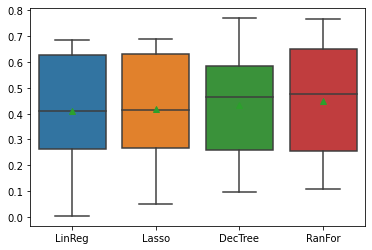

In [121]:
reg_summary = df_plot = pd.DataFrame(
        {'LinReg': scores_linreg,
         'Lasso': scores_lasso,
         'DecTree': scores_treereg,
         'RanFor': scores_rfr
        }
)

sns.boxplot(data = reg_summary, showmeans=True)
plt.show()

Der Random Forest ist für die Vorhersage des Umsatzes am besten geeignet, da es am meisten Varianz aufklärt (R²)

## 5. Prognose auf Qualifikationsdaten & Ergebnisse

### 5.1 Training der finalen Modelle

#### Training des besten Klassifikationsmodells (Random Forest Classifier) auf den gesamten Datensatz

In [122]:
RanForClass_final = best_RanFor.fit(x_RanFor, y_RanFor)

#### Training des besten Regressionsmodells (Random Forest Regressor) auf den gesamten Datensatz

In [123]:
RanForReg_final = best_rf.fit(x_rf, y_rf)

### 5.2 Prognosen Katalonia

#### Qualifikationsdaten laden

In [124]:
df_qual = pd.read_csv("Qualifikationsdaten.csv")

#### Allgemeine Informationen

In [125]:
display(df_qual.info())
display(df_qual.head(10))
print('Anzahl verschiedener Einträge:')
display(df_qual.nunique(axis=0, dropna=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 300 non-null    int64 
 1   Land               300 non-null    object
 2   Quelle             300 non-null    object
 3   Transaktionen      300 non-null    int64 
 4   letzte Aenderung   300 non-null    int64 
 5   erste Aenderung    300 non-null    int64 
 6   Online-Bestellung  300 non-null    bool  
 7   Geschlecht         300 non-null    object
 8   Adresstyp          300 non-null    object
dtypes: bool(1), int64(4), object(4)
memory usage: 19.2+ KB


None

,ID,Land,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Geschlecht,Adresstyp
0,1944,Inland,H,2,1710,1746,False,w,Privatadresse
1,243,Inland,O,1,3517,3747,False,w,Firmenadresse
2,1878,Inland,B,0,3500,3500,True,m,Firmenadresse
3,1632,Inland,A,1,4188,4188,False,w,Firmenadresse
4,391,Inland,D,1,3278,3278,True,w,Firmenadresse
5,335,Inland,C,1,2404,2404,False,m,Firmenadresse
6,823,Ausland,W,1,155,155,False,m,Firmenadresse
7,297,Ausland,U,3,283,640,False,w,Firmenadresse
8,1406,Inland,H,2,1498,1512,False,m,Privatadresse
9,14,Inland,A,5,2081,2438,False,m,Firmenadresse


Anzahl verschiedener Einträge:


ID                   300
Land                   2
Quelle                15
Transaktionen         10
letzte Aenderung     246
erste Aenderung      248
Online-Bestellung      2
Geschlecht             2
Adresstyp              2
dtype: int64

#### Data preparation

In [126]:
# Dataframe der Qualifikationsdaten muss auf die gleiche Basis gebracht werden wie die Test- & Trainigsdaten 

# Ersetze Inland und Ausland gegen 1 und 0
df_qual["Land"].replace("Inland", 1, inplace=True)
df_qual["Land"].replace("Ausland", 0, inplace=True)

# Ersetze Online-Bestellung gegen 1 und 0
df_qual.loc[df["Online-Bestellung"] == True, "Online-Bestellung"] = 1
df_qual.loc[df["Online-Bestellung"] == False, "Online-Bestellung"] = 0
df_qual["Online-Bestellung"] = df_qual["Online-Bestellung"].astype(int)
             
# Ersetze Geschlechter gegen 1 und 0
df_qual["Geschlecht"].replace("w", 1, inplace=True)
df_qual["Geschlecht"].replace("m", 0, inplace=True)

# Ersetzte Adresstypen gegen 1 und 0
df_qual["Adresstyp"].replace("Privatadresse", 1, inplace=True)
df_qual["Adresstyp"].replace("Firmenadresse", 0, inplace=True)

# Benenne Variablen um, damit Inhalt eindeutiger
df_qual = df_qual.rename(columns={'Land': 'Inland', 'Geschlecht': 'Weiblich', 'Adresstyp': 'Privatadresse'})

# Ersetzte Quellen  gegen numerische Werte
code = 1
for i in sorted(sorted(df_qual["Quelle"].unique())):
    df_qual["Quelle"].replace(to_replace = i, value = code, inplace = True)
    code += 1 

In [127]:
display(df_qual.head(10))

,ID,Inland,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse
0,1944,1,6,2,1710,1746,0,1,1
1,243,1,8,1,3517,3747,1,1,0
2,1878,1,2,0,3500,3500,0,0,0
3,1632,1,1,1,4188,4188,0,1,0
4,391,1,4,1,3278,3278,0,1,0
5,335,1,3,1,2404,2404,1,0,0
6,823,0,14,1,155,155,0,0,0
7,297,0,13,3,283,640,1,1,0
8,1406,1,6,2,1498,1512,1,0,1
9,14,1,1,5,2081,2438,0,0,0


#### Vorhersagen

In [128]:
# Vorhersage Kaufwahrscheinlichkeit
wkauf = RanForClass_final.predict_proba(df_qual[expl_var_ranfor_nodummy])
wkauf = wkauf[:,1]
df_qual['Kauf-Wkt.'] = wkauf

# Bestimmung angepasste Kaufwahrscheinlichkeit
df_qual['angepasste Kauf-Wkt.'] = wkauf*0.106

# Vorhersage Umsatz
umsatz = RanForReg_final.predict(df_qual[expl_var_rf])
df_qual['Umsatzprognose'] = umsatz

# Bestimmung Umsatzerwartungswert
df_qual['Umsatzerwartungswert'] = df_qual['Umsatzprognose']*df_qual['angepasste Kauf-Wkt.']

# Bestimmung Kosten
df_qual['Kosten'] = 2

# Bestimmung Ergebniserwartungswert
df_qual['Ergebniserwartungswert'] = df_qual['Umsatzerwartungswert']-df_qual['Kosten']

df_qual.head(20)

,ID,Inland,Quelle,Transaktionen,letzte Aenderung,erste Aenderung,Online-Bestellung,Weiblich,Privatadresse,Kauf-Wkt.,angepasste Kauf-Wkt.,Umsatzprognose,Umsatzerwartungswert,Kosten,Ergebniserwartungswert
0,1944,1,6,2,1710,1746,0,1,1,0.094816,0.010051,137.439585,1.381339,2,-0.618661
1,243,1,8,1,3517,3747,1,1,0,0.451485,0.047857,128.027775,6.127079,2,4.127079
2,1878,1,2,0,3500,3500,0,0,0,0.000267,0.000028,128.027775,0.003623,2,-1.996377
3,1632,1,1,1,4188,4188,0,1,0,0.452412,0.047956,128.027775,6.139655,2,4.139655
4,391,1,4,1,3278,3278,0,1,0,0.485149,0.051426,128.027775,6.583925,2,4.583925
5,335,1,3,1,2404,2404,1,0,0,0.585209,0.062032,128.027775,7.941845,2,5.941845
6,823,0,14,1,155,155,0,0,0,0.739924,0.078432,153.818597,12.064295,2,10.064295
7,297,0,13,3,283,640,1,1,0,0.912542,0.096729,382.110274,36.961331,2,34.961331
8,1406,1,6,2,1498,1512,1,0,1,0.107764,0.011423,137.439585,1.569974,2,-0.430026
9,14,1,1,5,2081,2438,0,0,0,0.941417,0.099790,373.965656,37.318090,2,35.318090


#### Export Qualifikationsdatensatz in Excel

In [129]:
df_qual.to_excel("Prognose.xlsx")

#### Profitkurve: Erwarteter Ergebnisbeitrag



Maximaler Ergebnisbeitrag:


,Anzahl versendeter Mailings,Kumulierter Ergebnisbeitrag
82,227,2835.707392




Profit Kurve:


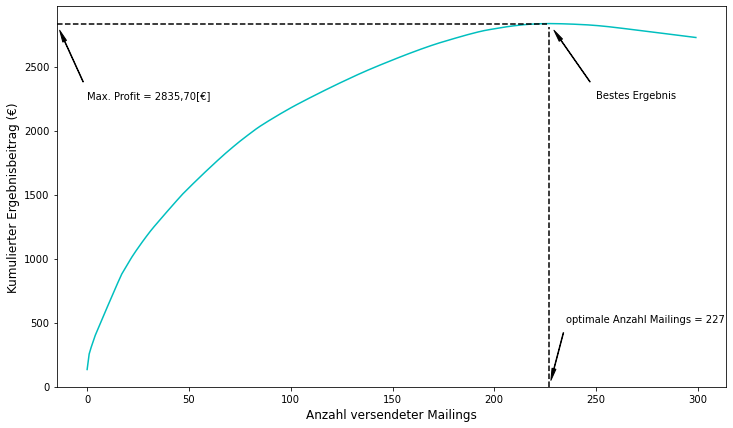

In [130]:
print("\n")

cumvalues = df_qual[['Ergebniserwartungswert']].sort_values(by = 'Ergebniserwartungswert', axis = 0, ascending=False).cumsum()

max_profit = pd.DataFrame({"Anzahl versendeter Mailings": np.arange(0,300,1), 'Kumulierter Ergebnisbeitrag': cumvalues["Ergebniserwartungswert"]})

print('\033[1m'"Maximaler Ergebnisbeitrag:")
display(max_profit.sort_values(by = 'Kumulierter Ergebnisbeitrag', axis = 0, ascending=False).head(1))

print("\n")
print('\033[1m''Profit Kurve:')

fig = plt.figure(figsize=(12,7))
plt.plot(np.arange(0,300,1), cumvalues, c="c")
plt.xlabel("Anzahl versendeter Mailings", fontsize=12)
plt.ylabel("Kumulierter Ergebnisbeitrag (€)", fontsize=12)
plt.axhline(y=2835.707392, xmin=0, xmax=227/310, c="k", linestyle= '--')
plt.axvline(x=227, ymin=0, ymax=2835.707392/3000, c="k", linestyle= '--')

arrow_properties = dict(
        facecolor="black", width=0.5,
        headwidth=4, shrink=0.1
)

label_x_max = 250
label_y_max = 2250
arrow_x_max = 227
arrow_y_max = 2835.707392

plt.annotate(
        "Bestes Ergebnis",
        xy=(arrow_x_max, arrow_y_max),
        xytext=(label_x_max, label_y_max),
        arrowprops=arrow_properties
)

label_x_profit = 0
label_y_profit = 2250
arrow_x_profit = -15
arrow_y_profit = 2835.707392

plt.annotate(
        "Max. Profit = 2835,70[€]",
        xy=(arrow_x_profit, arrow_y_profit),
        xytext=(label_x_profit, label_y_profit),
        arrowprops=arrow_properties
)

label_x_mailings = 235
label_y_mailings = 500
arrow_x_mailings = 227
arrow_y_mailings = 0

plt.annotate(
        "optimale Anzahl Mailings = 227",
        xy=(arrow_x_mailings, arrow_y_mailings),
        xytext=(label_x_mailings, label_y_mailings),
        arrowprops=arrow_properties
)

plt.savefig("Profitkurve")

plt.show()



## 6. Ausblick: Künftige Verbesserungen der Prognose

###  6.1 Durch veränderte Datenbasis

#### Aktualisierungen der Datenbasis

- Die aktuelle Prognose basiert auf den aktuellen Daten und sollte fortlaufend um aktualisierte Daten ergänzt werden
- Dadurch können Markttrends, gestiegene Kaufkraft der Kunden, etc. berücksichtigt werden
- Auch neue Daten durch neue Mitglieder im Konsortium der Händler aus dem die Daten bezogen werden können interessant sein

#### Schrittweise Durchführung der weiteren Mailings 

- Das Modell greift aktuell lediglich auf 2.000 Datensätze zu, 18.000 Datensätze der ersten Testrunde sind nicht berücksichtigt
- Diese weiteren Datensätze sind vermutlich wenig interessant, da sie nahezu ausschließlich Nicht-Käufer beinhalten
- Es besteht die Möglichkeit, weitere 180.000 Datensätze aus dem Pool des Konsortiums zu beziehen
- Diese 180.000 Datensätze sollten für ein optimales Ergebnis nicht gebündelt bezogen werden. Stattdessen ist es sinnvoll, diese wie gehabt in weiteren kleinen "Test-Sets" (z.B. weiterhin je 20.000) zu beziehen, diese Mailings zu versenden und das Modell jeweils um die Ergebnisse des aktuellsten Mailings zu ergänzen
- Dadurch verbessert sich das Modell immer weiter & die Accuracy würde womöglich weiter ansteigen

#### Erhebung zusätzlicher Daten

- Die Datenbasis enthält aktuell sehr wenig spezifische Daten
- Alleine eine weitere Spezifizierung bestehender Daten könnte interessante Ansätze liefern (z.B. Angebe von Ländern statt Unterscheidung Inland/Ausland)
- Die Klassifikation in Käufer/Nicht-Käufer liefert bereits eine brauchbare Genauigkeit
- Die Umsatzprognose ist erwartungsgemäß deutlich schwächer, da das Modell weder genauere Daten zum Käufer (Alter, Kaufkraft, Zahlungsart, etc.) beinhaltet noch Daten zu den gekauften Produkten 
- Die Erhebung weiterer Kundendaten (v.a. demographische) wäre wünschenswert, müsste jedoch aus datenschutzrechtlicher Sicht geprüft werden 

### 6.2 Durch weitere Modelle (Beispiel Neuronale Netze)

#### Library Import

In [131]:
# ! pip install tensorflow
import tensorflow as tf

#### Split in Test- & Trainingsdaten

In [132]:
x_train_dummy_nn, x_test_dummy_nn, y_train_dummy_nn, y_test_dummy_nn = train_test_split(X_dummy, Y_dummy, random_state = 42)
x_train_nodummy_nn, x_test_nodummy_nn, y_train_nodummy_nn, y_test_nodummy_nn = train_test_split(X_nodummy, Y_nodummy, random_state = 42)

#### Neuronale Netze - Initialisierung & Training

In [133]:
#initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=11) # seeded initializer
    
neural_network = tf.keras.Sequential() # instance of model
    
# Input layer
neural_network.add(
    tf.keras.layers.Dense(
        units=x_train_dummy_nn.shape[1],
        #kernel_initializer=initializer, # initialitzation of weights
        input_shape=[x_train_dummy_nn.shape[1]] # e.g. shape is (350 x 2) => shape[1]=2
    )
)
    
# Hidden layer(s)
neural_network.add(
    tf.keras.layers.Dense(
        units=10, # use param for number of units
        activation="relu", # sigmoid, softmax, tanh, exponential, ...
        #kernel_initializer=initializer # initialitzation of weights
    )
)

# Hidden layer(s)
neural_network.add(
    tf.keras.layers.Dense(
        units=10, # use param for number of units
        activation="relu", # sigmoid, softmax, tanh, exponential, ...
        #kernel_initializer=initializer # initialitzation of weights
    )
)

# Output Layer
neural_network.add(
    tf.keras.layers.Dense(
        units=1, # regression problem typically one single output value
        #kernel_initializer=initializer # initialitzation of weights
    )
)
    
# Stochastic gradient decent
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

#Alternatives
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001) #0.001

    
neural_network.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["mse", "mae"] # could be used to evaluate multiple error metrics during training
)
    
# Start training process of neural network
history = neural_network.fit(
    x = x_train_dummy_nn, 
    y = y_train_dummy_nn, 
    epochs=500, # An epoch is an iteration over the entire x and y data provided.
    validation_data=(x_test_dummy_nn, y_test_dummy_nn) # could also use: validation_split=0.3
)
    
# Training done
    
y_prediction_train = neural_network.predict(x_train_dummy_nn)
y_prediction_test = neural_network.predict(x_test_dummy_nn)

Epoch 1/500
20/20 [==============================] - 1s 41ms/step - loss: 1101076.8839 - mse: 1101076.8839 - mae: 901.6145 - val_loss: 247617.7344 - val_mse: 247617.7344 - val_mae: 422.6726
Epoch 2/500
20/20 [==============================] - 0s 5ms/step - loss: 141201.3668 - mse: 141201.3668 - mae: 294.8441 - val_loss: 65553.6094 - val_mse: 65553.6094 - val_mae: 141.5002
Epoch 3/500
20/20 [==============================] - 0s 6ms/step - loss: 54098.4138 - mse: 54098.4138 - mae: 132.6083 - val_loss: 57649.3203 - val_mse: 57649.3203 - val_mae: 131.3044
Epoch 4/500
20/20 [==============================] - 0s 5ms/step - loss: 44895.5550 - mse: 44895.5550 - mae: 124.3186 - val_loss: 53752.6992 - val_mse: 53752.6992 - val_mae: 138.9730
Epoch 5/500
20/20 [==============================] - 0s 5ms/step - loss: 49344.1933 - mse: 49344.1933 - mae: 129.3551 - val_loss: 54272.1914 - val_mse: 54272.1914 - val_mae: 133.7337
Epoch 6/500
20/20 [==============================] - 0s 4ms/step - loss: 462

20/20 [==============================] - 0s 4ms/step - loss: 33564.9901 - mse: 33564.9901 - mae: 110.3065 - val_loss: 52532.1719 - val_mse: 52532.1719 - val_mae: 128.4912
Epoch 90/500
20/20 [==============================] - 0s 4ms/step - loss: 41007.8730 - mse: 41007.8730 - mae: 114.7357 - val_loss: 52526.6016 - val_mse: 52526.6016 - val_mae: 127.9475
Epoch 91/500
20/20 [==============================] - 0s 3ms/step - loss: 47839.9349 - mse: 47839.9349 - mae: 122.1999 - val_loss: 53108.6680 - val_mse: 53108.6680 - val_mae: 137.4960
Epoch 92/500
20/20 [==============================] - 0s 4ms/step - loss: 41769.3125 - mse: 41769.3125 - mae: 130.5995 - val_loss: 52908.3242 - val_mse: 52908.3242 - val_mae: 125.9372
Epoch 93/500
20/20 [==============================] - 0s 4ms/step - loss: 34523.1968 - mse: 34523.1968 - mae: 113.2239 - val_loss: 51891.4688 - val_mse: 51891.4688 - val_mae: 129.4071
Epoch 94/500
20/20 [==============================] - 0s 4ms/step - loss: 38570.9866 - mse: 3

20/20 [==============================] - 0s 4ms/step - loss: 34643.9075 - mse: 34643.9075 - mae: 114.0275 - val_loss: 49953.8203 - val_mse: 49953.8203 - val_mae: 131.4527
Epoch 178/500
20/20 [==============================] - 0s 3ms/step - loss: 41580.7499 - mse: 41580.7499 - mae: 119.3593 - val_loss: 49952.5273 - val_mse: 49952.5273 - val_mae: 120.8126
Epoch 179/500
20/20 [==============================] - 0s 3ms/step - loss: 37393.6323 - mse: 37393.6323 - mae: 116.8494 - val_loss: 49295.3047 - val_mse: 49295.3047 - val_mae: 120.2575
Epoch 180/500
20/20 [==============================] - 0s 3ms/step - loss: 30491.6110 - mse: 30491.6110 - mae: 109.9775 - val_loss: 50607.0938 - val_mse: 50607.0938 - val_mae: 133.3072
Epoch 181/500
20/20 [==============================] - 0s 4ms/step - loss: 32820.3342 - mse: 32820.3342 - mae: 109.5661 - val_loss: 48716.1250 - val_mse: 48716.1250 - val_mae: 124.6469
Epoch 182/500
20/20 [==============================] - 0s 3ms/step - loss: 33442.9289 - m

20/20 [==============================] - 0s 3ms/step - loss: 28119.1082 - mse: 28119.1082 - mae: 107.3280 - val_loss: 43706.7617 - val_mse: 43706.7617 - val_mae: 112.4230
Epoch 266/500
20/20 [==============================] - 0s 4ms/step - loss: 27872.0587 - mse: 27872.0587 - mae: 105.2026 - val_loss: 41601.2031 - val_mse: 41601.2031 - val_mae: 113.3494
Epoch 267/500
20/20 [==============================] - 0s 3ms/step - loss: 28411.1495 - mse: 28411.1495 - mae: 100.3748 - val_loss: 42049.2070 - val_mse: 42049.2070 - val_mae: 113.6830
Epoch 268/500
20/20 [==============================] - 0s 4ms/step - loss: 29014.8928 - mse: 29014.8928 - mae: 100.1218 - val_loss: 42319.3320 - val_mse: 42319.3320 - val_mae: 109.3054
Epoch 269/500
20/20 [==============================] - 0s 4ms/step - loss: 28203.3537 - mse: 28203.3537 - mae: 94.2530 - val_loss: 42019.0312 - val_mse: 42019.0312 - val_mae: 108.2744
Epoch 270/500
20/20 [==============================] - 0s 3ms/step - loss: 36344.6877 - ms

20/20 [==============================] - 0s 4ms/step - loss: 20314.5259 - mse: 20314.5259 - mae: 93.4725 - val_loss: 38638.0234 - val_mse: 38638.0234 - val_mae: 106.9911
Epoch 354/500
20/20 [==============================] - 0s 3ms/step - loss: 22481.3770 - mse: 22481.3769 - mae: 96.2033 - val_loss: 40635.2930 - val_mse: 40635.2930 - val_mae: 111.2316
Epoch 355/500
20/20 [==============================] - 0s 4ms/step - loss: 19110.8940 - mse: 19110.8940 - mae: 94.7782 - val_loss: 39624.4180 - val_mse: 39624.4180 - val_mae: 120.2974
Epoch 356/500
20/20 [==============================] - 0s 4ms/step - loss: 29392.1148 - mse: 29392.1148 - mae: 105.3995 - val_loss: 38393.7930 - val_mse: 38393.7930 - val_mae: 108.8865
Epoch 357/500
20/20 [==============================] - 0s 3ms/step - loss: 18582.5361 - mse: 18582.5361 - mae: 89.5043 - val_loss: 43640.9336 - val_mse: 43640.9336 - val_mae: 139.4945
Epoch 358/500
20/20 [==============================] - 0s 3ms/step - loss: 27993.9130 - mse: 

20/20 [==============================] - 0s 4ms/step - loss: 28806.9975 - mse: 28806.9975 - mae: 99.2224 - val_loss: 42198.3906 - val_mse: 42198.3906 - val_mae: 115.7921
Epoch 442/500
20/20 [==============================] - 0s 3ms/step - loss: 21497.3502 - mse: 21497.3502 - mae: 96.1792 - val_loss: 39376.5312 - val_mse: 39376.5312 - val_mae: 108.8579
Epoch 443/500
20/20 [==============================] - 0s 4ms/step - loss: 24085.6530 - mse: 24085.6530 - mae: 99.6644 - val_loss: 40019.9844 - val_mse: 40019.9844 - val_mae: 112.0786
Epoch 444/500
20/20 [==============================] - 0s 3ms/step - loss: 29948.8057 - mse: 29948.8057 - mae: 106.6638 - val_loss: 40849.8320 - val_mse: 40849.8320 - val_mae: 112.6585
Epoch 445/500
20/20 [==============================] - 0s 3ms/step - loss: 28687.0395 - mse: 28687.0395 - mae: 103.5909 - val_loss: 43062.6680 - val_mse: 43062.6680 - val_mae: 117.9191
Epoch 446/500
20/20 [==============================] - 0s 3ms/step - loss: 24917.8364 - mse:

#### Bewertungsansätze eines Neuronalen Netzwerks

In [134]:
print("RMSE:", np.sqrt(mean_squared_error(y_prediction_test, y_test_dummy))) #RMSE

RMSE: 192.93152989417587


#### Kennzahlen der Random Forest Regression für direkten Vergleich

In [135]:
y_pred_reg_rf = best_treereg.predict(x_test_rf)

print("RMSE:", np.sqrt(mean_squared_error(y_pred_reg_rf, y_test_rf))) #RMSE

RMSE: 196.52161865273078


#### Erkenntnisse

- Bereits ein nicht optimiertes Neuronales Netzwerk erreicht einen nahezu identischen RMSE (Root-Mean-Squared-Error) wie die optimierte beste Regressionsform, die Random Forest Regression
- Neuronale Netzwerke bieten zahlreiche Optimierungsansätze (u.a. Anzahl Layer, Anzahl Units pro Layer, Art des Optimizers) - Auch hier könnte im Nachgang mittels Grid Search eine Analyse der optimalen Parameter betreiben werden